# Classifying Crash Severity in Chicago
Original Dataset: https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if

The task:
- Explore what factors determine crash severity measured by crash costs
- Build an ML model that predicts what is what is most likely to lead to expensive crashes
- I hypothesize that the latitude longitude values will be useful for predicting hotspots of crash severity, and thus a good method of determining placement of speed cameras (when combined with information on posted speed limit and reason for crash).

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme(style="whitegrid")
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import joblib
from sklearn.metrics import RocCurveDisplay
pd.set_option('display.max_columns', None)
import eli5
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy.stats import uniform
from sklearn.model_selection import RepeatedStratifiedKFold
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV

## Load and Explore Data

In [2]:
crash_df = pd.read_csv("Traffic_Crashes_-_Crashes.csv")
crash_df.head()

CRASH_RECORD_ID     RD_NO  \
0  4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...  JC343143   
1  009e9e67203442370272e1a13d6ee51a4155dac65e583d...  JA329216   
2  ee9283eff3a55ac50ee58f3d9528ce1d689b1c4180b4c4...  JD292400   
3  f8960f698e870ebdc60b521b2a141a5395556bc3704191...  JD293602   
4  8eaa2678d1a127804ee9b8c35ddf7d63d913c14eda61d6...  JD290451   

  CRASH_DATE_EST_I              CRASH_DATE  POSTED_SPEED_LIMIT  \
0              NaN  07/10/2019 05:56:00 PM                  35   
1              NaN  06/30/2017 04:00:00 PM                  35   
2              NaN  07/10/2020 10:25:00 AM                  30   
3              NaN  07/11/2020 01:00:00 AM                  30   
4              NaN  07/08/2020 02:00:00 PM                  20   

  TRAFFIC_CONTROL_DEVICE      DEVICE_CONDITION WEATHER_CONDITION  \
0            NO CONTROLS           NO CONTROLS             CLEAR   
1      STOP SIGN/FLASHER  FUNCTIONING PROPERLY             CLEAR   
2         TRAFFIC SIGNAL  FUNCTIONING PROPERLY             CLEAR   
3            NO CONTROLS           NO CONTROLS             CLEAR   
4            NO CONTROLS           NO CONTROLS             CLEAR   

  LIGHTING_CONDITION      FIRST_CRASH_TYPE                  TRAFFICWAY_TYPE  \
0           DAYLIGHT               TURNING                          ONE-WAY   
1           DAYLIGHT               TURNING                      NOT DIVIDED   
2           DAYLIGHT              REAR END                         FOUR WAY   
3           DARKNESS  PARKED MOTOR VEHICLE  DIVIDED - W/MEDIAN (NOT RAISED)   
4           DAYLIGHT  PARKED MOTOR VEHICLE                         DRIVEWAY   

   LANE_CNT           ALIGNMENT ROADWAY_SURFACE_COND ROAD_DEFECT  \
0       NaN  STRAIGHT AND LEVEL                  DRY  NO DEFECTS   
1       4.0  STRAIGHT AND LEVEL                  DRY  NO DEFECTS   
2       NaN  STRAIGHT AND LEVEL                  DRY  NO DEFECTS   
3       NaN  STRAIGHT AND LEVEL                  DRY  NO DEFECTS   
4       NaN  STRAIGHT AND LEVEL                  DRY  NO DEFECTS   

                  REPORT_TYPE                        CRASH_TYPE  \
0                    ON SCENE            NO INJURY / DRIVE AWAY   
1                    ON SCENE  INJURY AND / OR TOW DUE TO CRASH   
2                    ON SCENE            NO INJURY / DRIVE AWAY   
3  NOT ON SCENE (DESK REPORT)            NO INJURY / DRIVE AWAY   
4                    ON SCENE            NO INJURY / DRIVE AWAY   

  INTERSECTION_RELATED_I NOT_RIGHT_OF_WAY_I HIT_AND_RUN_I        DAMAGE  \
0                    NaN                NaN           NaN   OVER $1,500   
1                      Y                NaN           NaN   OVER $1,500   
2                    NaN                NaN           NaN   OVER $1,500   
3                    NaN                NaN             Y  $500 OR LESS   
4                    NaN                NaN           NaN   OVER $1,500   

     DATE_POLICE_NOTIFIED        PRIM_CONTRIBUTORY_CAUSE  \
0  07/10/2019 06:16:00 PM               IMPROPER BACKING   
1  06/30/2017 04:01:00 PM  FAILING TO YIELD RIGHT-OF-WAY   
2  07/10/2020 10:25:00 AM  FAILING TO YIELD RIGHT-OF-WAY   
3  07/11/2020 08:30:00 AM            UNABLE TO DETERMINE   
4  07/08/2020 02:15:00 PM            UNABLE TO DETERMINE   

          SEC_CONTRIBUTORY_CAUSE  STREET_NO STREET_DIRECTION  STREET_NAME  \
0            UNABLE TO DETERMINE       2158                N  MARMORA AVE   
1                 NOT APPLICABLE       8301                S   CICERO AVE   
2  FAILING TO YIELD RIGHT-OF-WAY       1632                E      67TH ST   
3            UNABLE TO DETERMINE        110                E      51ST ST   
4            UNABLE TO DETERMINE        412                W     OHARE ST   

   BEAT_OF_OCCURRENCE PHOTOS_TAKEN_I STATEMENTS_TAKEN_I DOORING_I WORK_ZONE_I  \
0              2515.0            NaN                NaN       NaN         NaN   
1               834.0            NaN                NaN       NaN         NaN   
2               331.0        

In [3]:
crash_df.columns

Index(['CRASH_RECORD_ID', 'RD_NO', 'CRASH_DATE_EST_I', 'CRASH_DATE',
       'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
       'TRAFFICWAY_TYPE', 'LANE_CNT', 'ALIGNMENT', 'ROADWAY_SURFACE_COND',
       'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I',
       'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'DATE_POLICE_NOTIFIED',
       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO',
       'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE',
       'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I',
       'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'NUM_UNITS',
       'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL',
       'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
       'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
       'INJURIES_UNKNOWN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
       'LA

In [4]:
crash_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588920 entries, 0 to 588919
Data columns (total 49 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH_RECORD_ID                588920 non-null  object 
 1   RD_NO                          584817 non-null  object 
 2   CRASH_DATE_EST_I               44509 non-null   object 
 3   CRASH_DATE                     588920 non-null  object 
 4   POSTED_SPEED_LIMIT             588920 non-null  int64  
 5   TRAFFIC_CONTROL_DEVICE         588920 non-null  object 
 6   DEVICE_CONDITION               588920 non-null  object 
 7   WEATHER_CONDITION              588920 non-null  object 
 8   LIGHTING_CONDITION             588920 non-null  object 
 9   FIRST_CRASH_TYPE               588920 non-null  object 
 10  TRAFFICWAY_TYPE                588920 non-null  object 
 11  LANE_CNT                       198979 non-null  float64
 12  ALIGNMENT                     

In [5]:
crash_df.describe()

POSTED_SPEED_LIMIT      LANE_CNT      STREET_NO  BEAT_OF_OCCURRENCE  \
count       588920.000000  1.989790e+05  588920.000000       588915.000000   
mean            28.335529  1.333175e+01    3675.001379         1237.831974   
std              6.354884  2.961824e+03    2906.189942          706.047555   
min              0.000000  0.000000e+00       0.000000          111.000000   
25%             30.000000  2.000000e+00    1225.000000          712.000000   
50%             30.000000  2.000000e+00    3200.000000         1135.000000   
75%             30.000000  4.000000e+00    5600.000000         1822.000000   
max             99.000000  1.191625e+06  451100.000000         6100.000000   

           NUM_UNITS  INJURIES_TOTAL  INJURIES_FATAL  INJURIES_INCAPACITATING  \
count  588920.000000   587701.000000   587701.000000            587701.000000   
mean        2.034331        0.181900        0.001147                 0.019668   
std         0.449558        0.553688        0.036692                 0.164098   
min         1.000000        0.000000        0.000000                 0.000000   
25%         2.000000        0.000000        0.000000                 0.000000   
50%         2.000000        0.000000        0.000000                 0.000000   
75%         2.000000        0.000000        0.000000                 0.000000   
max        18.000000       21.000000        4.000000                 7.000000   

       INJURIES_NON_INCAPACITATING  INJURIES_REPORTED_NOT_EVIDENT  \
count                587701.000000                  587701.000000   
mean                      0.102050                       0.059035   
std                       0.412153                       0.311519   
min                       0.000000                       0.000000   
25%                       0.000000                       0.000000   
50%                       0.000000                       0.000000   
75%                       0.000000                       0.000000   
max                      21.000000                      15.000000   

       INJURIES_NO_INDICATION  INJURIES_UNKNOWN     CRASH_HOUR  \
count           587701.000000          587701.0  588920.000000   
mean                 2.014642               0.0      13.229571   
std                  1.162874               0.0       5.530839   
min                  0.000000               0.0       0.000000   
25%                  1.000000               0.0       9.000000   
50%                  2.000000               0.0      14.000000   
75%                  2.000000               0.0      17.000000   
max                 61.000000               0.0      23.000000   

       CRASH_DAY_OF_WEEK    CRASH_MONTH       LATITUDE      LONGITUDE  
count      588920.000000  588920.000000  585408.000000  585408.000000  
mean            4.126314       6.730896      41.854570     -87.673259  
std             1.979078       3.469818       0.330367       0.670764  
min             1.000000       1.000000       0.000000     -87.936193  
25%             2.000000       4.000000      41.780978     -87.721315  
50%             4.000000       7.000000      41.874654     -87.673537  
75%             6.000000      10.000000      41.923953     -87.632837  
max             7.000000      12.000000      42.022780       0.000000

In [6]:
# Lets check nulls as a proportion of all entries
crash_df.isna().sum()/588920

CRASH_RECORD_ID                  0.000000
RD_NO                            0.006967
CRASH_DATE_EST_I                 0.924423
CRASH_DATE                       0.000000
POSTED_SPEED_LIMIT               0.000000
TRAFFIC_CONTROL_DEVICE           0.000000
DEVICE_CONDITION                 0.000000
WEATHER_CONDITION                0.000000
LIGHTING_CONDITION               0.000000
FIRST_CRASH_TYPE                 0.000000
TRAFFICWAY_TYPE                  0.000000
LANE_CNT                         0.662129
ALIGNMENT                        0.000000
ROADWAY_SURFACE_COND             0.000000
ROAD_DEFECT                      0.000000
REPORT_TYPE                      0.025516
CRASH_TYPE                       0.000000
INTERSECTION_RELATED_I           0.771760
NOT_RIGHT_OF_WAY_I               0.952893
HIT_AND_RUN_I                    0.695363
DAMAGE                           0.000000
DATE_POLICE_NOTIFIED             0.000000
PRIM_CONTRIBUTORY_CAUSE          0.000000
SEC_CONTRIBUTORY_CAUSE           0

#### Drop columns that are not useful for analysis or have too many na

In [7]:
crash_df.drop(["CRASH_RECORD_ID", "RD_NO", "CRASH_DATE_EST_I", "CRASH_DATE", "LANE_CNT", 
               "REPORT_TYPE", "INTERSECTION_RELATED_I", "NOT_RIGHT_OF_WAY_I", "HIT_AND_RUN_I", 
               "DATE_POLICE_NOTIFIED", "BEAT_OF_OCCURRENCE", "PHOTOS_TAKEN_I", "STATEMENTS_TAKEN_I", 
               "DOORING_I", "WORK_ZONE_I", "WORK_ZONE_TYPE", "WORKERS_PRESENT_I", "NUM_UNITS"], axis=1, 
              inplace=True)
crash_df.shape, crash_df.columns

((588920, 31),
 Index(['POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
        'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
        'TRAFFICWAY_TYPE', 'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT',
        'CRASH_TYPE', 'DAMAGE', 'PRIM_CONTRIBUTORY_CAUSE',
        'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO', 'STREET_DIRECTION',
        'STREET_NAME', 'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL',
        'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
        'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
        'INJURIES_UNKNOWN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
        'LATITUDE', 'LONGITUDE', 'LOCATION'],
       dtype='object'))

#### Drop rows that still have na, only lose 400ish out of 580,000+

In [8]:
crash_df.dropna(axis=0, how="any", inplace=True)
crash_df.shape

(584184, 31)

## Explore Individual Data

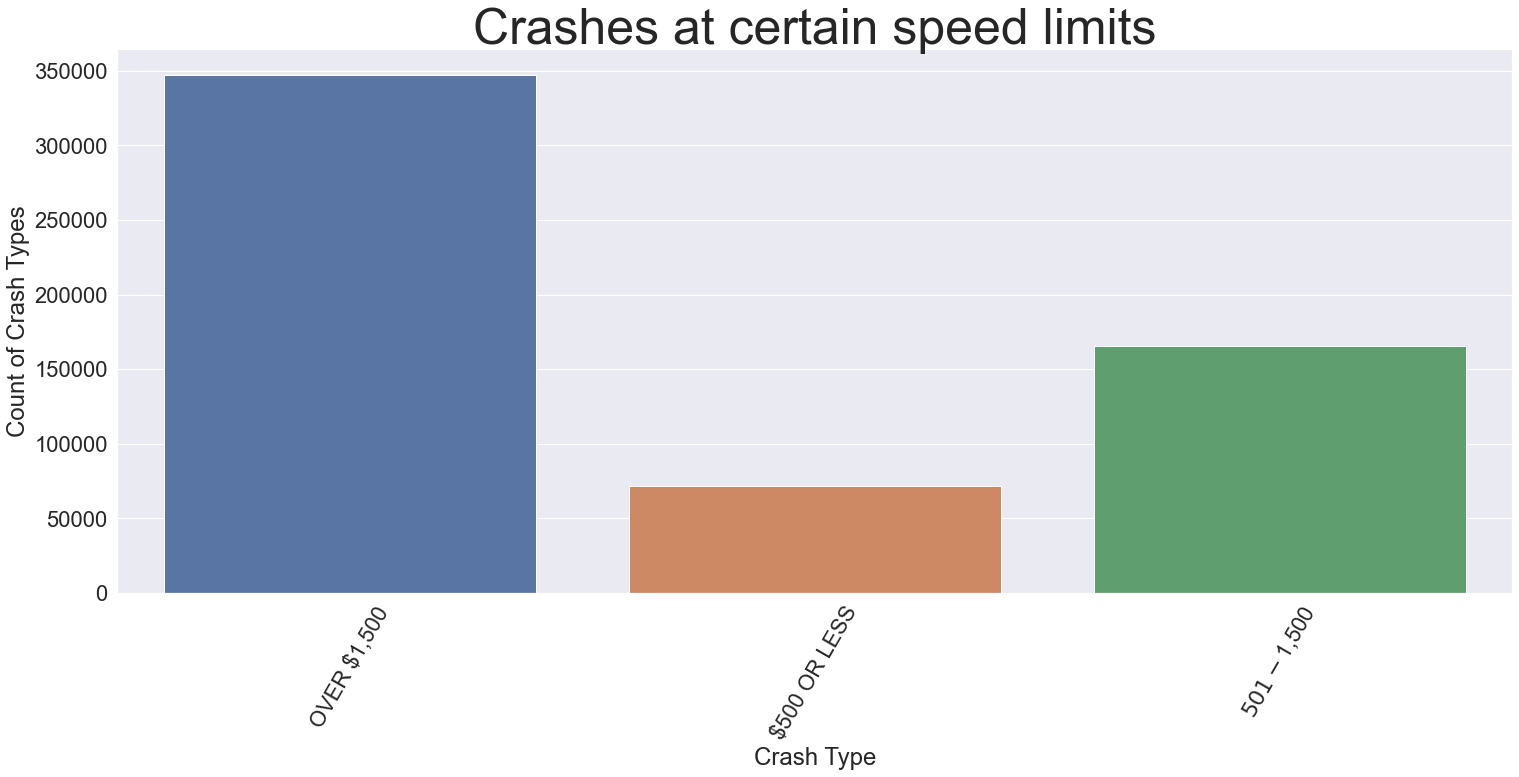

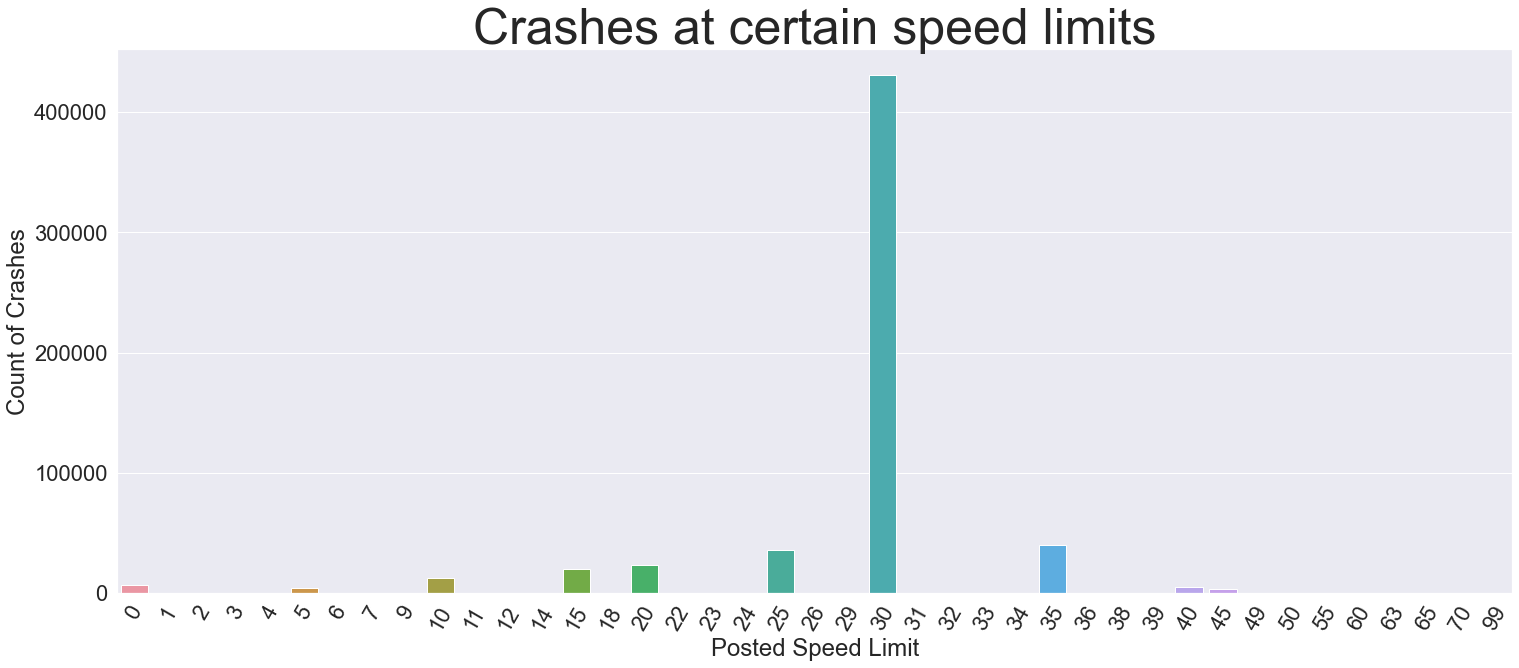

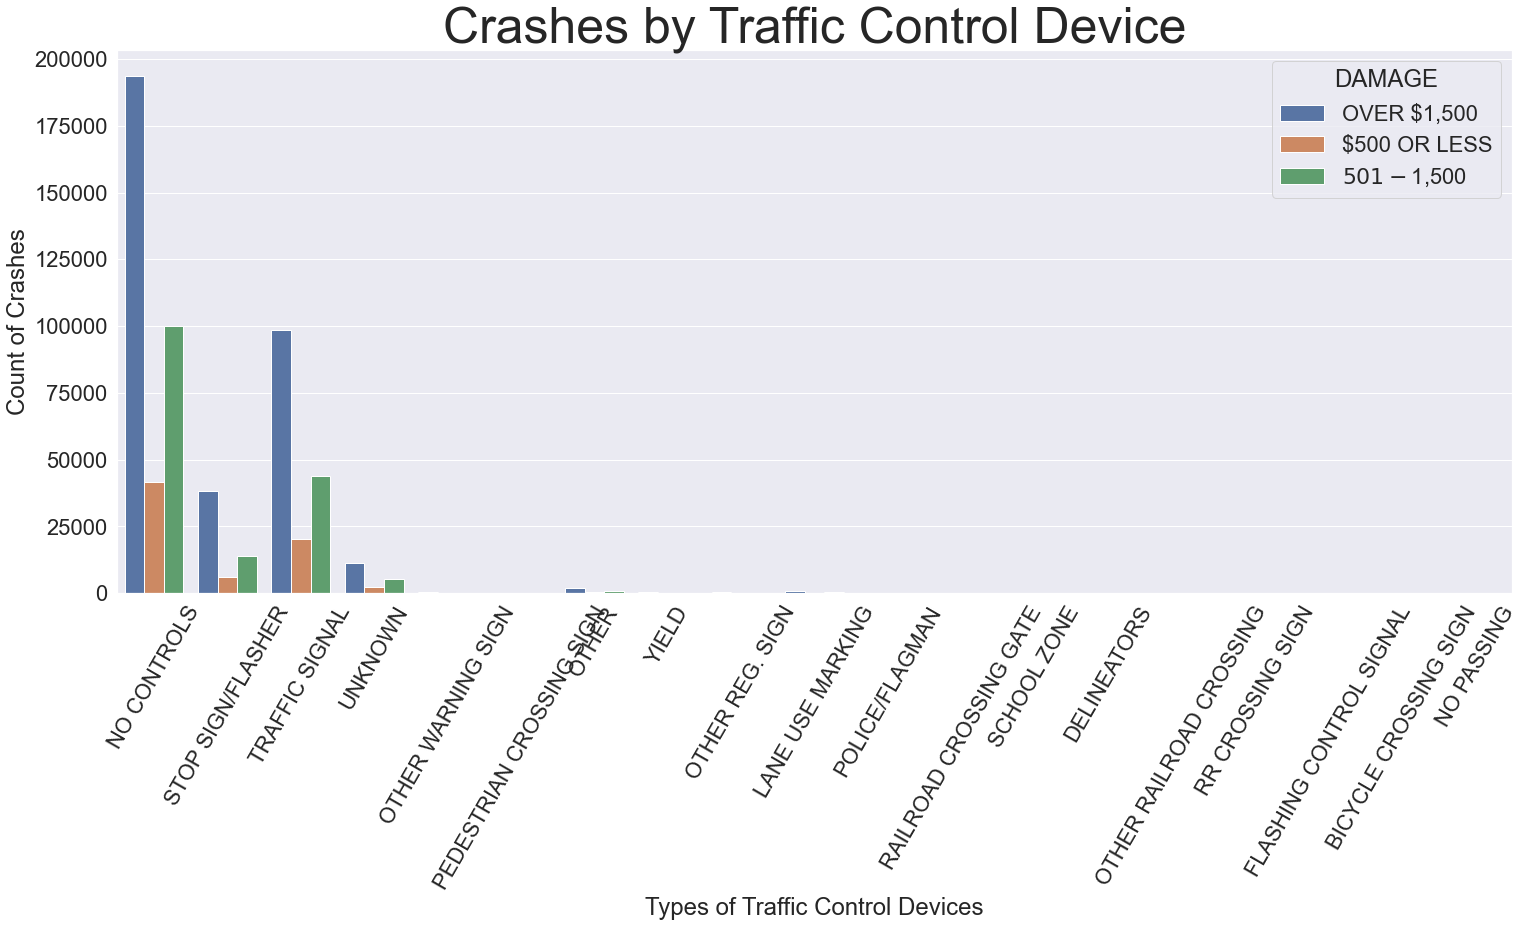

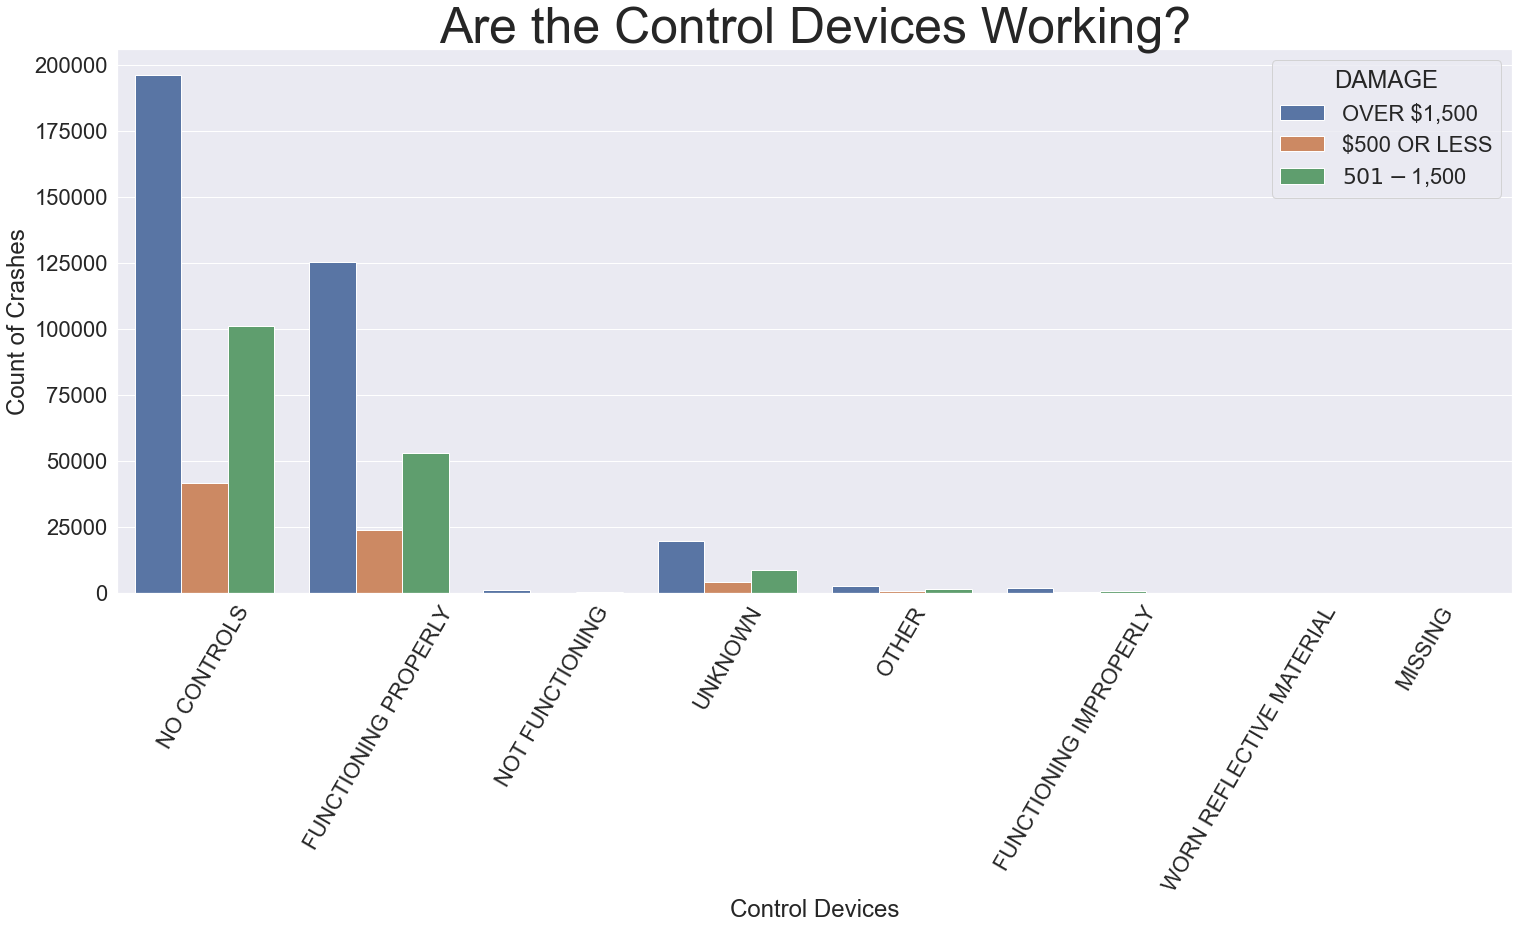

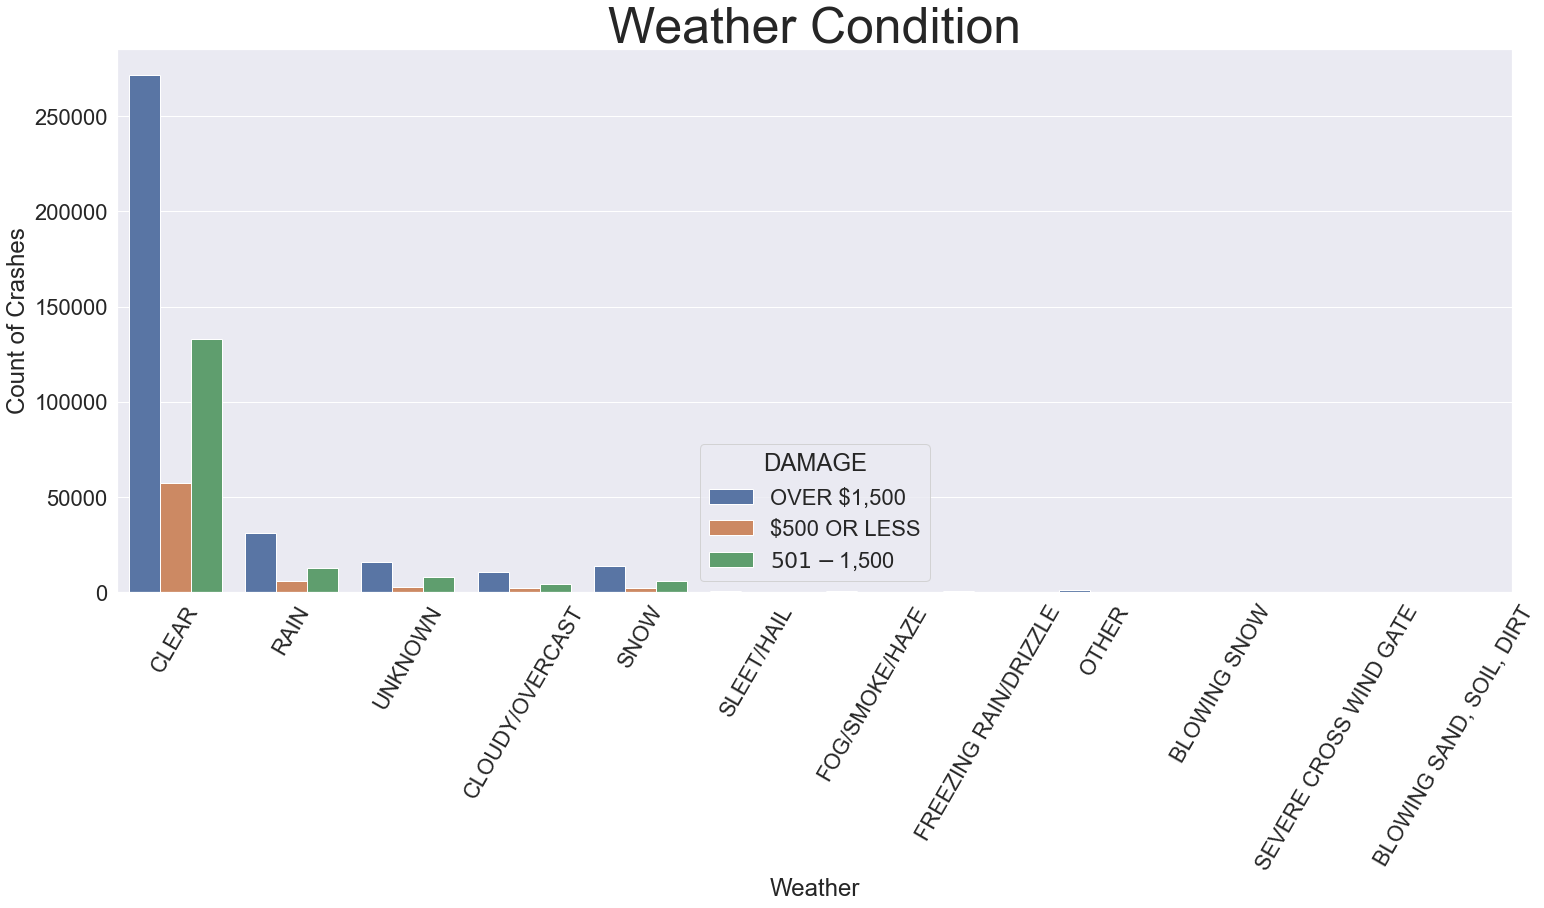

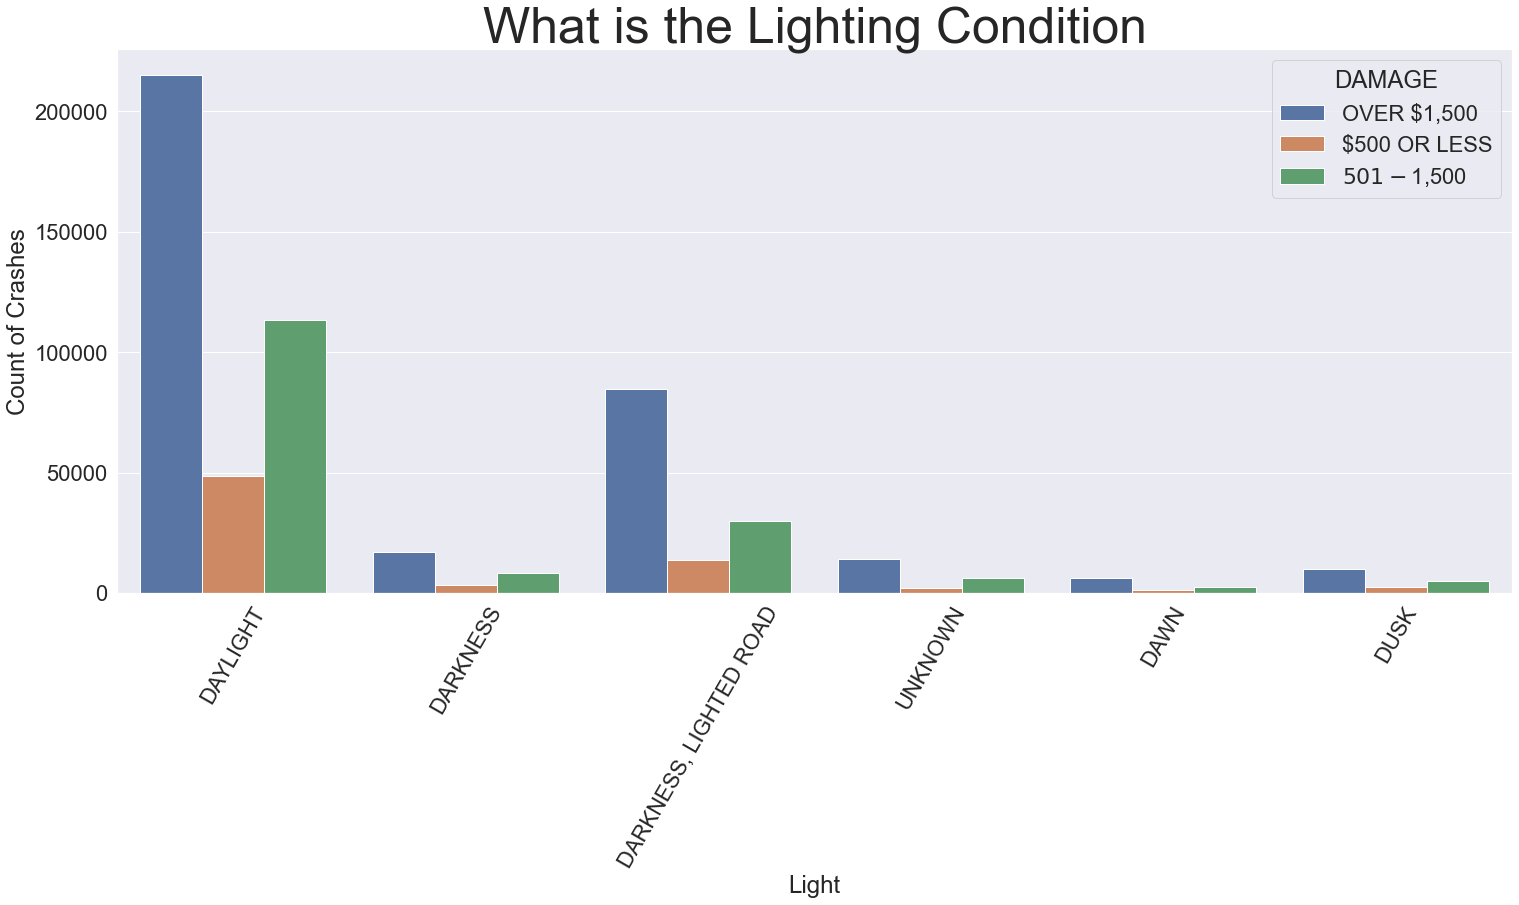

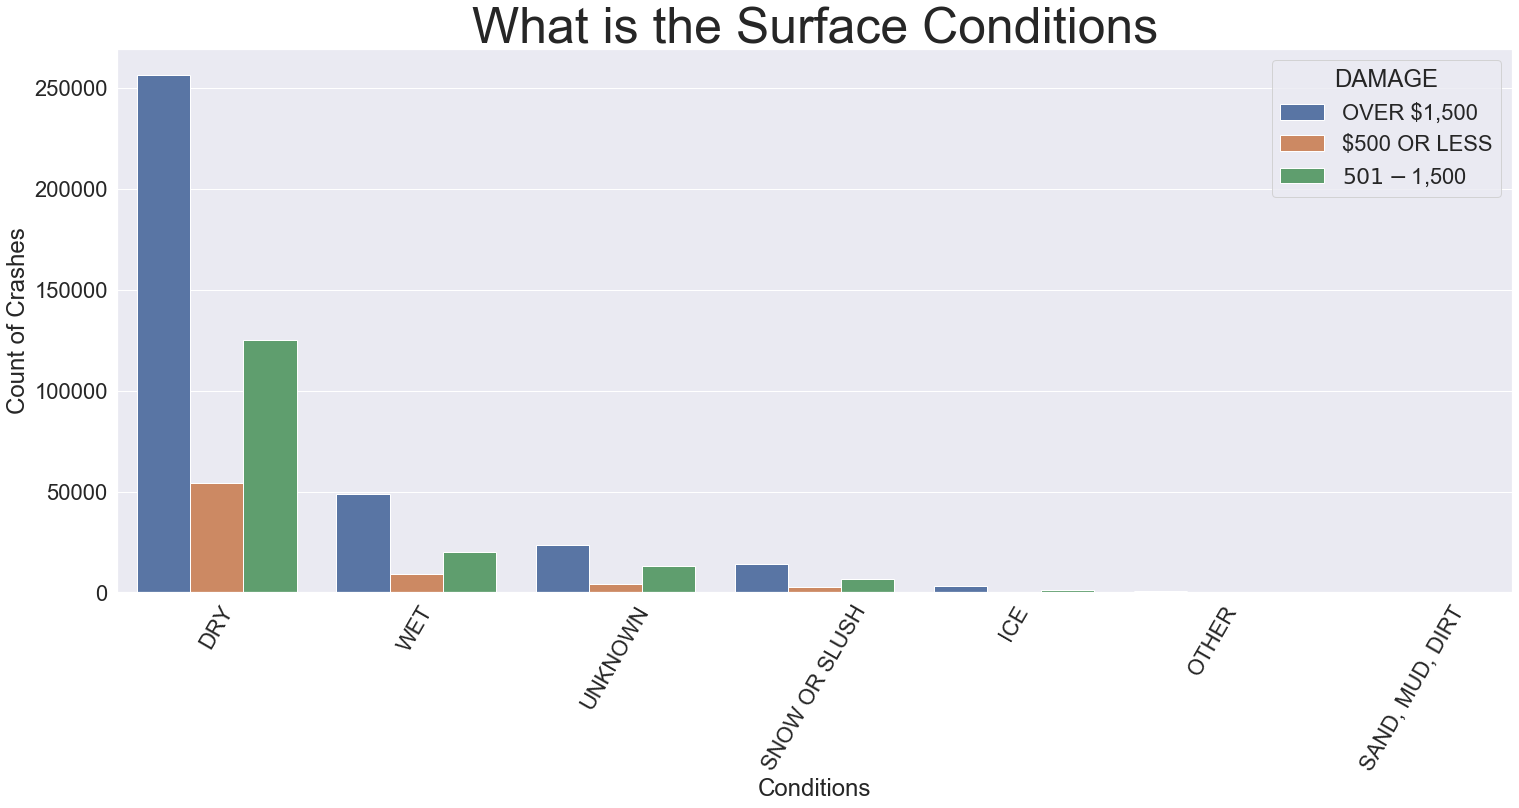

In [11]:
sns.set(font_scale = 2)
fig_7, ax_7 = plt.subplots(figsize=(25, 10))
ax_7 = sns.countplot(x="DAMAGE", data=crash_df, ax=ax_7)
ticks = ax_7.set_xticklabels(ax_7.get_xticklabels(), rotation=60)
title = ax_7.set_title("Crashes at certain speed limits", size=50)
x_label = ax_7.set_xlabel("Crash Type")
y_label = ax_7.set_ylabel("Count of Crash Types")

fig_1, ax_1 = plt.subplots(figsize=(25, 10))
ax_1 = sns.countplot(x="POSTED_SPEED_LIMIT", data=crash_df, ax=ax_1)
ticks = ax_1.set_xticklabels(ax_1.get_xticklabels(), rotation=60)
title = ax_1.set_title("Crashes at certain speed limits", size=50)
x_label = ax_1.set_xlabel("Posted Speed Limit")
y_label = ax_1.set_ylabel("Count of Crashes")

fig, ax_2 = plt.subplots(figsize=(25, 10))
ax_2 = sns.countplot(x="TRAFFIC_CONTROL_DEVICE", hue="DAMAGE", data=crash_df, ax=ax_2)
ticks = ax_2.set_xticklabels(ax_2.get_xticklabels(), rotation=60)
title = ax_2.set_title("Crashes by Traffic Control Device", size=50)
x_label = ax_2.set_xlabel("Types of Traffic Control Devices")
y_label = ax_2.set_ylabel("Count of Crashes")

fig, ax_3 = plt.subplots(figsize=(25, 10))
ax_3 = sns.countplot(x="DEVICE_CONDITION", hue="DAMAGE", data=crash_df, ax=ax_3)
ticks = ax_3.set_xticklabels(ax_3.get_xticklabels(), rotation=60)
title = ax_3.set_title("Are the Control Devices Working?", size=50)
x_label = ax_3.set_xlabel("Control Devices")
y_label = ax_3.set_ylabel("Count of Crashes")

fig, ax_4 = plt.subplots(figsize=(25, 10))
ax_4 = sns.countplot(x="WEATHER_CONDITION", hue="DAMAGE", data=crash_df, ax=ax_4)
ticks = ax_4.set_xticklabels(ax_4.get_xticklabels(), rotation=60)
title = ax_4.set_title("Weather Condition", size=50)
x_label = ax_4.set_xlabel("Weather")
y_label = ax_4.set_ylabel("Count of Crashes")

fig, ax_5 = plt.subplots(figsize=(25, 10))
ax_5 = sns.countplot(x="LIGHTING_CONDITION", hue="DAMAGE", data=crash_df, ax=ax_5)
ticks = ax_5.set_xticklabels(ax_5.get_xticklabels(), rotation=60)
title = ax_5.set_title("What is the Lighting Condition", size=50)
x_label = ax_5.set_xlabel("Light")
y_label = ax_5.set_ylabel("Count of Crashes")

fig, ax_6 = plt.subplots(figsize=(25, 10))
ax_6 = sns.countplot(x="ROADWAY_SURFACE_COND", hue="DAMAGE", data=crash_df, ax=ax_6)
ticks = ax_6.set_xticklabels(ax_6.get_xticklabels(), rotation=60)
title = ax_6.set_title("What is the Surface Conditions", size=50)
x_label = ax_6.set_xlabel("Conditions")
y_label = ax_6.set_ylabel("Count of Crashes")

Any specific times that have special outcomes?

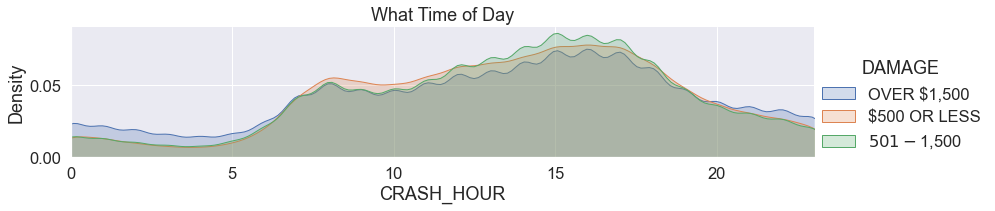

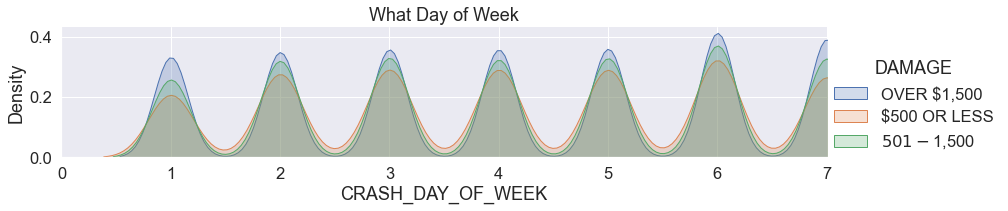

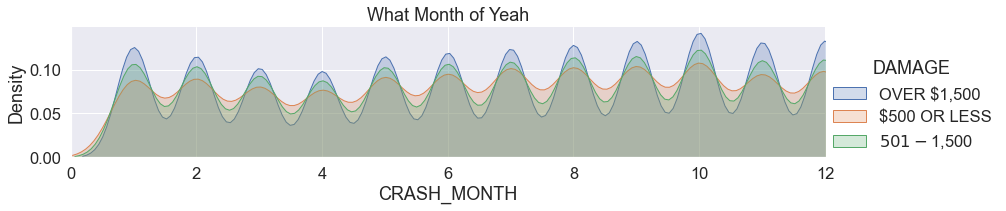

In [12]:
sns.set(font_scale = 1.5)
facet_1 = sns.FacetGrid(crash_df, hue="DAMAGE",aspect=4)
facet_1.map(sns.kdeplot,'CRASH_HOUR',shade= True)
facet_1.set(xlim=(0, crash_df['CRASH_HOUR'].max()))
facet_1.set(title="What Time of Day")
facet_1.add_legend()

facet_2 = sns.FacetGrid(crash_df, hue="DAMAGE",aspect=4)
facet_2.map(sns.kdeplot,'CRASH_DAY_OF_WEEK',shade= True)
facet_2.set(xlim=(0, crash_df['CRASH_DAY_OF_WEEK'].max()))
facet_2.set(title="What Day of Week")
facet_2.add_legend()

facet_3 = sns.FacetGrid(crash_df, hue="DAMAGE",aspect=4)
facet_3.map(sns.kdeplot,'CRASH_MONTH',shade= True)
facet_3.set(xlim=(0, crash_df['CRASH_MONTH'].max()))
facet_3.set(title="What Month of Yeah")
facet_3.add_legend()

Mondays look particularly bad for some reason, also early morning leads to a higher amount of expensive crashes, and mid day has more middle value crashes.

### Lets Try Location Data

In [13]:
lon_max = crash_df.LONGITUDE.max()
lon_min = crash_df.LONGITUDE.min()
lat_max = crash_df.LATITUDE.max()
lat_min = crash_df.LATITUDE.min()

lon_max, lon_min, lat_max, lat_min

(0.0, -87.936192947, 42.022779861, 0.0)

In [14]:
# Looks like we have some bad data in the locations, lets drop those
crash_df = crash_df[crash_df.LONGITUDE != 0.0]
crash_df = crash_df[crash_df.LATITUDE != 0.0]
crash_df.shape

(584150, 31)

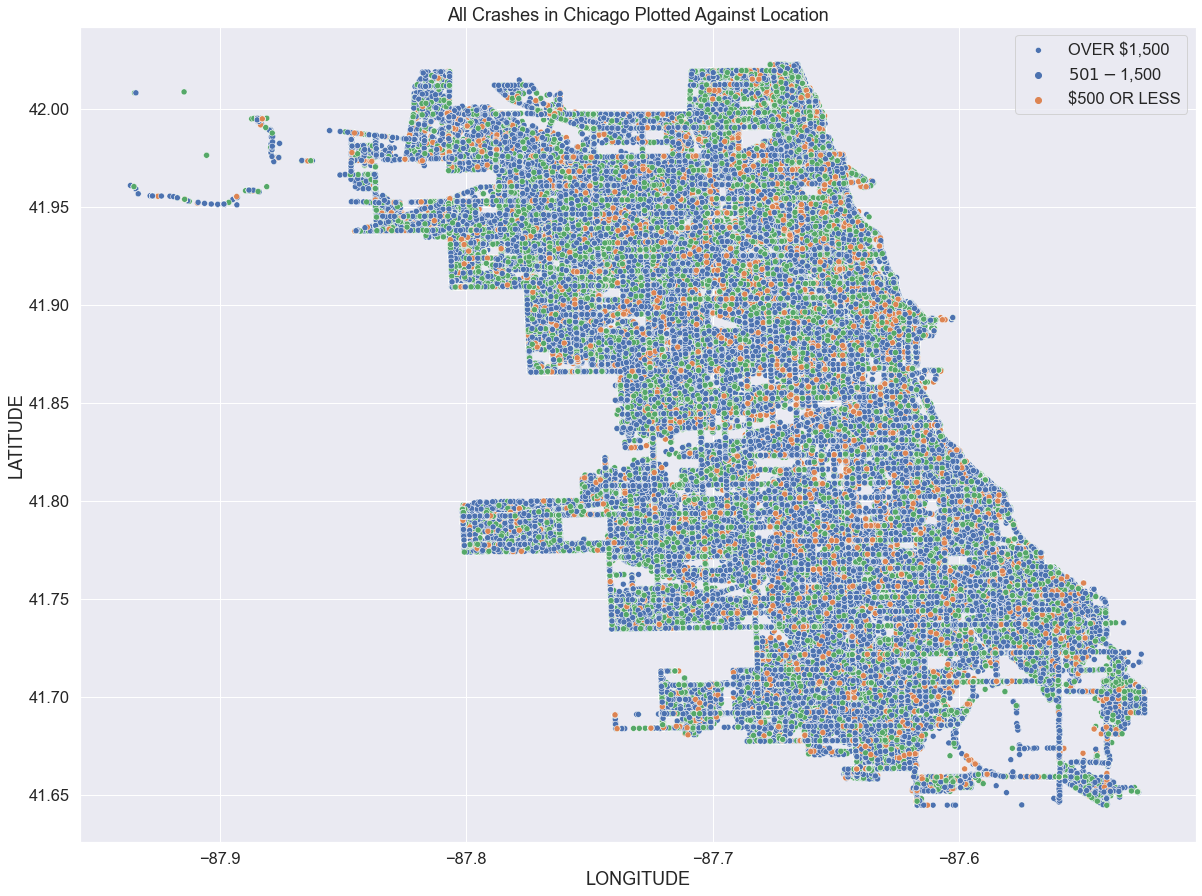

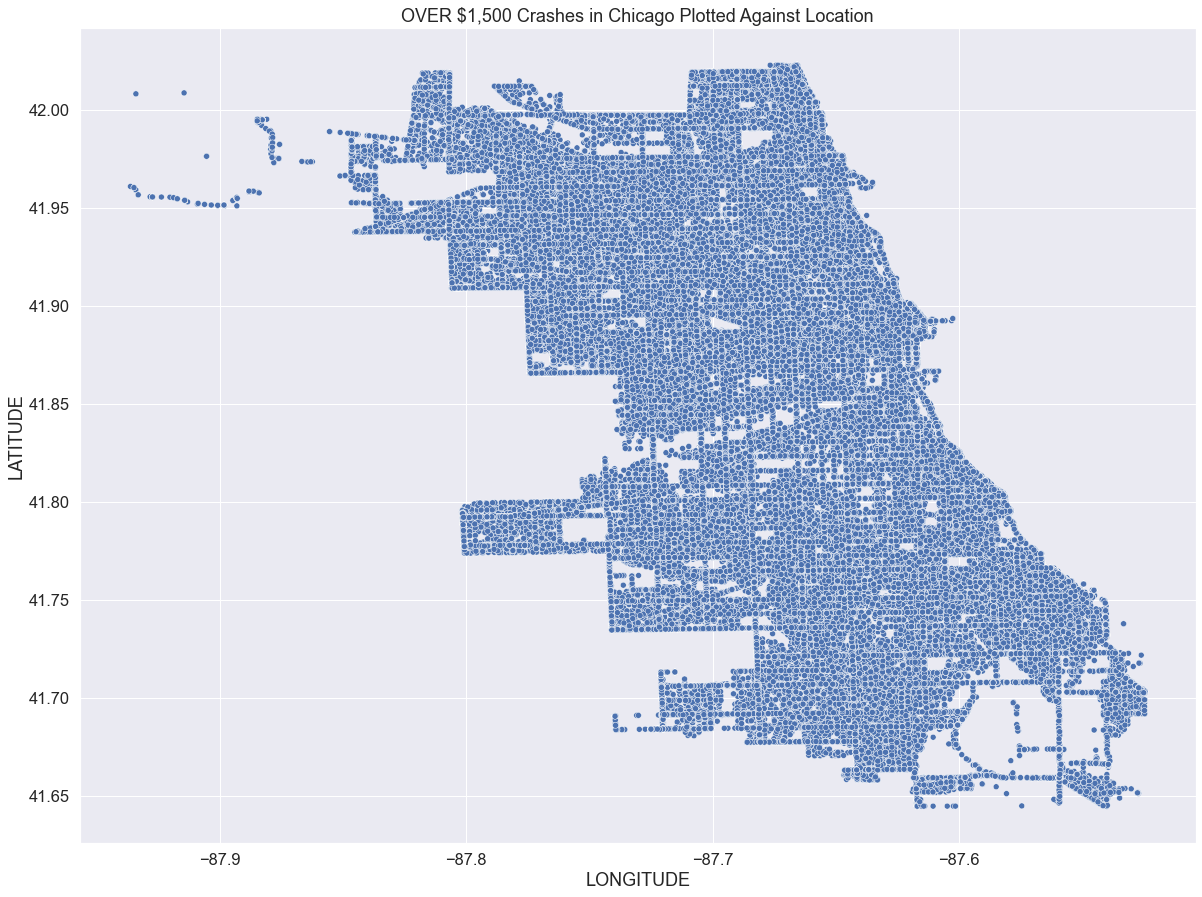

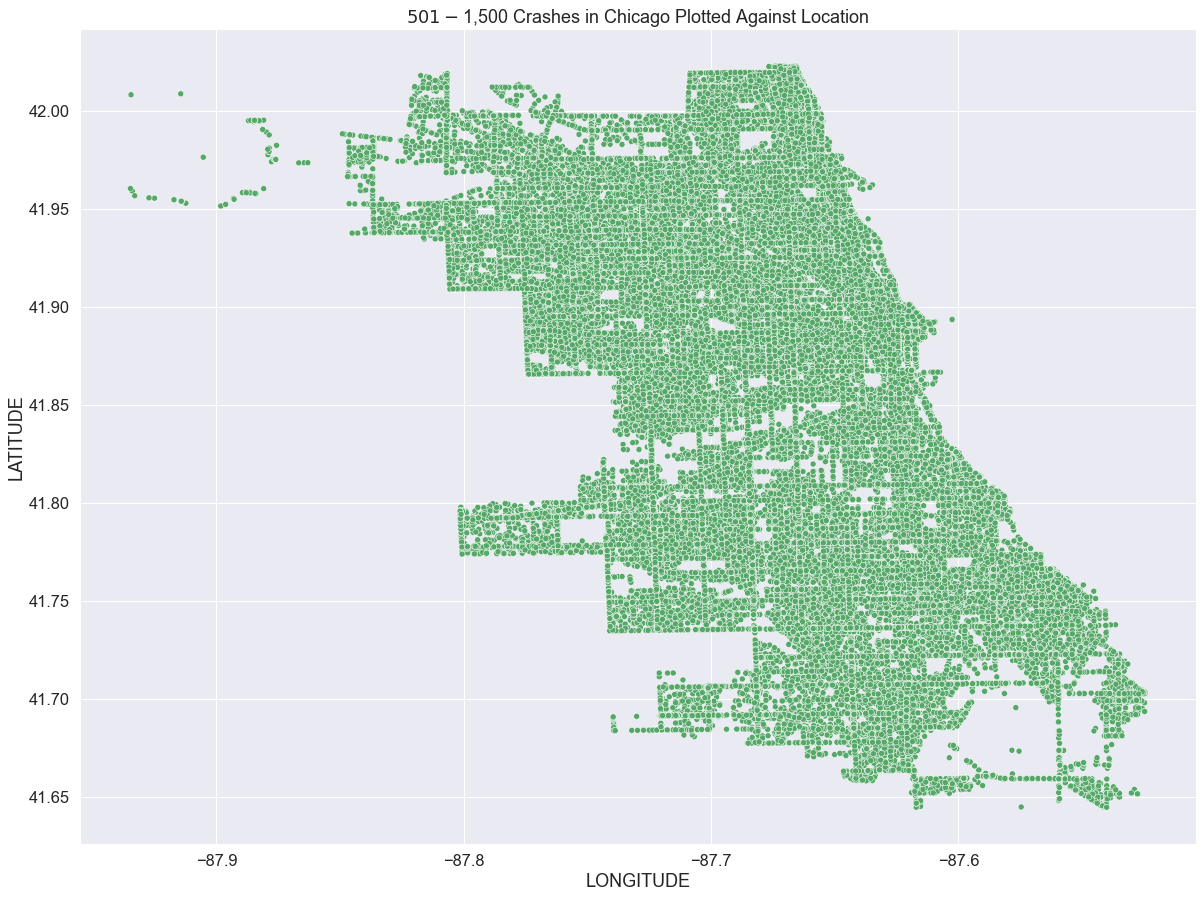

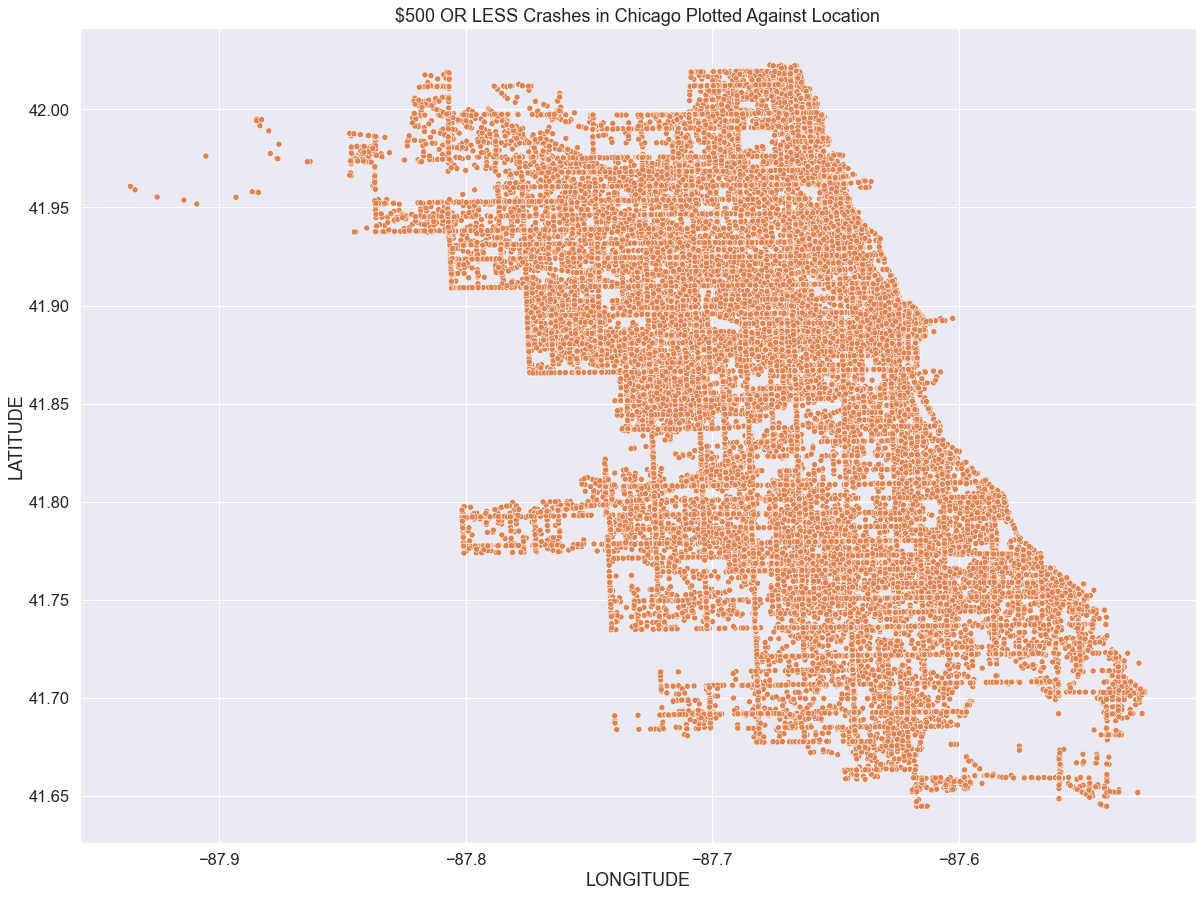

In [15]:
crash_df_loc = crash_df
crash_df_loc["color"] = None
color_dic = {"OVER $1,500": "#EE2110",
             "$501 - $1,500": "#E4EE10",
             "$500 OR LESS": "#39EE10"}
crash_df_loc["color"] = crash_df_loc["DAMAGE"].map(color_dic)

plt.figure(figsize=(20,15))
loc_plot = sns.scatterplot(x=crash_df_loc.LONGITUDE, 
                           y=crash_df_loc.LATITUDE,
                          hue=crash_df_loc.color)
loc_plot.set(title="All Crashes in Chicago Plotted Against Location")
plt.legend(labels=[x for x in color_dic])


plt.figure(figsize=(20,15))
loc_plot = sns.scatterplot(x=crash_df_loc.loc[crash_df_loc.DAMAGE == "OVER $1,500"].LONGITUDE, 
                           y=crash_df_loc.loc[crash_df_loc.DAMAGE == "OVER $1,500"].LATITUDE,
                          hue=crash_df_loc.color)
loc_plot.set(title="OVER $1,500 Crashes in Chicago Plotted Against Location")
plt.legend([],[], frameon=False)


plt.figure(figsize=(20,15))
loc_plot = sns.scatterplot(x=crash_df_loc.loc[crash_df_loc.DAMAGE == "$501 - $1,500"].LONGITUDE, 
                           y=crash_df_loc.loc[crash_df_loc.DAMAGE == "$501 - $1,500"].LATITUDE,
                          hue=crash_df_loc.color)
loc_plot.set(title="$501 - $1,500 Crashes in Chicago Plotted Against Location")
plt.legend([],[], frameon=False)


plt.figure(figsize=(20,15))
loc_plot = sns.scatterplot(x=crash_df_loc.loc[crash_df_loc.DAMAGE == "$500 OR LESS"].LONGITUDE, 
                           y=crash_df_loc.loc[crash_df_loc.DAMAGE == "$500 OR LESS"].LATITUDE,
                          hue=crash_df_loc.color)
loc_plot.set(title="$500 OR LESS Crashes in Chicago Plotted Against Location")
plt.legend([],[], frameon=False)

## Model Training and Evaluation

In [21]:
# All prior data processing steps from above, so data can be easily reset
crash_df = pd.read_csv("Traffic_Crashes_-_Crashes.csv")
crash_df.drop(["CRASH_RECORD_ID", "RD_NO", "CRASH_DATE_EST_I", "CRASH_DATE", "LANE_CNT", 
               "REPORT_TYPE", "INTERSECTION_RELATED_I", "NOT_RIGHT_OF_WAY_I", "HIT_AND_RUN_I", 
               "DATE_POLICE_NOTIFIED", "BEAT_OF_OCCURRENCE", "PHOTOS_TAKEN_I", "STATEMENTS_TAKEN_I", 
               "DOORING_I", "WORK_ZONE_I", "WORK_ZONE_TYPE", "WORKERS_PRESENT_I", "NUM_UNITS"], axis=1, inplace=True)
crash_df.dropna(axis=0, how="any", inplace=True)
crash_df = crash_df[crash_df.LONGITUDE != 0.0]
crash_df = crash_df[crash_df.LATITUDE != 0.0]


In [4]:
# Lets encode our target labels
le = preprocessing.LabelEncoder()
crash_df.DAMAGE = le.fit_transform(crash_df.DAMAGE)

In [5]:
#check Damage to make sure that worked
crash_df.head()

POSTED_SPEED_LIMIT TRAFFIC_CONTROL_DEVICE      DEVICE_CONDITION  \
0                  35            NO CONTROLS           NO CONTROLS   
1                  35      STOP SIGN/FLASHER  FUNCTIONING PROPERLY   
2                  30         TRAFFIC SIGNAL  FUNCTIONING PROPERLY   
3                  30            NO CONTROLS           NO CONTROLS   
5                  30         TRAFFIC SIGNAL  FUNCTIONING PROPERLY   

  WEATHER_CONDITION      LIGHTING_CONDITION      FIRST_CRASH_TYPE  \
0             CLEAR                DAYLIGHT               TURNING   
1             CLEAR                DAYLIGHT               TURNING   
2             CLEAR                DAYLIGHT              REAR END   
3             CLEAR                DARKNESS  PARKED MOTOR VEHICLE   
5             CLEAR  DARKNESS, LIGHTED ROAD               TURNING   

                   TRAFFICWAY_TYPE           ALIGNMENT ROADWAY_SURFACE_COND  \
0                          ONE-WAY  STRAIGHT AND LEVEL                  DRY   
1                      NOT DIVIDED  STRAIGHT AND LEVEL                  DRY   
2                         FOUR WAY  STRAIGHT AND LEVEL                  DRY   
3  DIVIDED - W/MEDIAN (NOT RAISED)  STRAIGHT AND LEVEL                  DRY   
5                      NOT DIVIDED  STRAIGHT AND LEVEL                  DRY   

  ROAD_DEFECT                        CRASH_TYPE  DAMAGE  \
0  NO DEFECTS            NO INJURY / DRIVE AWAY       2   
1  NO DEFECTS  INJURY AND / OR TOW DUE TO CRASH       2   
2  NO DEFECTS            NO INJURY / DRIVE AWAY       2   
3  NO DEFECTS            NO INJURY / DRIVE AWAY       0   
5  NO DEFECTS            NO INJURY / DRIVE AWAY       2   

         PRIM_CONTRIBUTORY_CAUSE         SEC_CONTRIBUTORY_CAUSE  STREET_NO  \
0               IMPROPER BACKING            UNABLE TO DETERMINE       2158   
1  FAILING TO YIELD RIGHT-OF-WAY                 NOT APPLICABLE       8301   
2  FAILING TO YIELD RIGHT-OF-WAY  FAILING TO YIELD RIGHT-OF-WAY       1632   
3            UNABLE TO DETERMINE            UNABLE TO DETERMINE        110   
5            UNABLE TO DETERMINE            UNABLE TO DETERMINE       8301   

  STREET_DIRECTION  STREET_NAME       MOST_SEVERE_INJURY  INJURIES_TOTAL  \
0                N  MARMORA AVE  NO INDICATION OF INJURY             0.0   
1                S   CICERO AVE  NO INDICATION OF INJURY             0.0   
2                E      67TH ST  NO INDICATION OF INJURY             0.0   
3                E      51ST ST  NO INDICATION OF INJURY             0.0   
5                S   CICERO AVE  NO INDICATION OF INJURY             0.0   

   INJURIES_FATAL  INJURIES_INCAPACITATING  INJURIES_NON_INCAPACITATING  \
0             0.0                      0.0                          0.0   
1             0.0                      0.0                          0.0   
2             0.0                      0.0                          0.0   
3             0.0                      0.0                          0.0   
5             0.0                      0.0                          0.0   

   INJURIES_REPORTED_NOT_EVIDENT  INJURIES_NO_INDICATION  INJURIES_UNKNOWN  \
0                            0.0                     3.0               0.0   
1                            0.0                     3.0               0.0   
2                            0.0                     3.0               0.0   
3                            0.0                     3.0               0.0   
5                            0.0                     2.0               0.0   

   CRASH_HOUR  CRASH_DAY_OF_WEEK  CRASH_MONTH   LATITUDE  LONGITUDE  \
0          17                  4            7  41.919664 -87.773288   
1          16                  6            6  41.741804 -87.740954   
2          10                  6            7  41.773456 -87.585022   
3           1                  7            7  41.802119 -87.622115   
5          22                  5            3  41.741804 -87.740954   

                                   LOCATION  
0  POINT (-87.7732

In [6]:
#Split out Damage into our y table
y = crash_df.DAMAGE
crash_df.drop("DAMAGE", axis=1, inplace=True)

In [7]:
# Drop location and Street No because it is not usable for next steps and is essentially repeated information
crash_df.drop(["LOCATION", "STREET_NO"], axis=1, inplace=True)

In [8]:
#Checking to make sure y is all good
y.head()

0    2
1    2
2    2
3    0
5    2
Name: DAMAGE, dtype: int32

In [9]:
# Large dataset so ok to split at 0.2
X_train, X_test, y_train, y_test = train_test_split(crash_df, y, test_size=0.2, random_state=42)

In [10]:
# Checking Output
X_train.shape

(467320, 28)

In [11]:
# encoding string variables and scaling numericals for use in the random forest classifier to see 
# if we can find feature importance

In [12]:
encode_col = ["TRAFFIC_CONTROL_DEVICE", "DEVICE_CONDITION", "WEATHER_CONDITION", 
              "LIGHTING_CONDITION", "FIRST_CRASH_TYPE", "TRAFFICWAY_TYPE", "ALIGNMENT", 
              "ROADWAY_SURFACE_COND", "ROAD_DEFECT", "CRASH_TYPE", "PRIM_CONTRIBUTORY_CAUSE",
              "SEC_CONTRIBUTORY_CAUSE", "STREET_DIRECTION", "STREET_NAME", "MOST_SEVERE_INJURY"]
scale_col = ["POSTED_SPEED_LIMIT", "CRASH_HOUR", "CRASH_DAY_OF_WEEK", "CRASH_MONTH"]

ct = ColumnTransformer([
    ("scaler", StandardScaler(), scale_col),
    ("encoder", OneHotEncoder(handle_unknown='ignore'), encode_col)],
    remainder="passthrough"
)
X_train_enc = ct.fit_transform(X_train)
X_test_enc = ct.transform(X_test)

In [23]:
X_train_enc.shape

(467320, 1719)

### Random Forest Test for time and output

In [241]:
rf_feat_reduc = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', 
                                       random_state = 42, verbose=3)
rf_feat_reduc.fit(X_train_enc, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=42)

Simple score output

In [243]:
rf_feat_reduc.score(X_test_enc, y_test)

0.5887357699221091

Checking the confusion matrix

In [18]:
y_pred = rf_feat_reduc.predict(X_test_enc)
print(pd.crosstab(le.inverse_transform(y_test), le.inverse_transform(y_pred), 
                  rownames=["Actual Damage"], colnames=["Predicted Damage"]))

Predicted Damage  $500 OR LESS  $501 - $1,500  OVER $1,500
Actual Damage                                             
$500 OR LESS              2397           3731         8092
$501 - $1,500             1596          11841        19509
OVER $1,500               2322          12798        54544


In [ ]:
# Save the model just in case
filename = 'rf_feat_reduc.sav'
joblib.dump(rf_feat_reduc, filename)

### Logistic Regression Test for time and output

In [30]:
%%timeit
logistic = LogisticRegression(max_iter=1000, multi_class="ovr", solver="liblinear", verbose=3)
logistic.fit(X_train_enc, y_train)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]1min 8s ± 517 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
logistic.score(X_test_enc, y_test)

0.6115980484464607

In [36]:
y_pred_log = logistic.predict(X_test_enc)
print(pd.crosstab(le.inverse_transform(y_test), le.inverse_transform(y_pred_log), 
                  rownames=["Actual Damage"], colnames=["Predicted Damage"]))


Predicted Damage  $500 OR LESS  $501 - $1,500  OVER $1,500
Actual Damage                                             
$500 OR LESS              2423           1102        10695
$501 - $1,500              616           3456        28874
OVER $1,500               1041           3049        65574


In [37]:
filename = 'logistic.pkl'
joblib.dump(logistic, filename)

['logistic.pkl']

### Linear SVC Test for time and output

In [40]:
%%time
svc_test = LinearSVC(dual=False, multi_class="ovr", random_state=42, verbose=3)
svc_test.fit(X_train_enc, y_train)

[LibLinear]CPU times: total: 1min 27s
Wall time: 1min 27s


LinearSVC(dual=False, random_state=42, verbose=3)

In [41]:
print(svc_test.score(X_test_enc, y_test))
y_pred_svc = svc_test.predict(X_test_enc)
print(pd.crosstab(le.inverse_transform(y_test), le.inverse_transform(y_pred_svc), 
                  rownames=["Actual Damage"], colnames=["Predicted Damage"]))

0.6110930411709321
Predicted Damage  $500 OR LESS  $501 - $1,500  OVER $1,500
Actual Damage                                             
$500 OR LESS              2519            854        10847
$501 - $1,500              627           2513        29806
OVER $1,500               1119           2183        66362


### Gridsearch for best estimator

In [63]:
%%time
l_gs = LogisticRegression(max_iter=1000, multi_class="ovr", solver="liblinear", verbose=3)
rf_gs = RandomForestClassifier(random_state = 42, verbose=3)
svc_gs = LinearSVC(dual=False, multi_class="ovr", random_state=42, verbose=3)

pipe = Pipeline(steps=[("estimator", l_gs)])
                
param_grid = [
    {
        "estimator": [LogisticRegression(max_iter=1000, multi_class="ovr", solver="liblinear", verbose=3)],
        "estimator__penalty": ["l2", "l1"],
        "estimator__C": np.logspace(-4, 4, 20)
    },
    {
        "estimator": [RandomForestClassifier(random_state = 42, verbose=3)],
        "estimator__n_estimators": [10, 100, 200],
        "estimator__criterion": ["gini", "entropy"],
        "estimator__max_depth": [None, 2, 5]
    },
    {
        "estimator": [LinearSVC(dual=False, multi_class="ovr", random_state=42, verbose=3)],
        "estimator__tol": [1e-4, 1e-5],
        "estimator__C": np.logspace(-4, 4, 20)
    }
]

search = GridSearchCV(pipe, param_grid, cv=5, verbose=3)
search.fit(X_train_enc, y_train)

Fitting 5 folds for each of 98 candidates, totalling 490 fits
[LibLinear][CV 1/5] END estimator=LogisticRegression(max_iter=1000, multi_class='ovr', solver='liblinear',
                   verbose=3), estimator__C=0.0001, estimator__penalty=l2;, score=0.593 total time=   6.1s
[LibLinear][CV 2/5] END estimator=LogisticRegression(max_iter=1000, multi_class='ovr', solver='liblinear',
                   verbose=3), estimator__C=0.0001, estimator__penalty=l2;, score=0.593 total time=   6.0s
[LibLinear][CV 3/5] END estimator=LogisticRegression(max_iter=1000, multi_class='ovr', solver='liblinear',
                   verbose=3), estimator__C=0.0001, estimator__penalty=l2;, score=0.593 total time=   6.1s
[LibLinear][CV 4/5] END estimator=LogisticRegression(max_iter=1000, multi_class='ovr', solver='liblinear',
                   verbose=3), estimator__C=0.0001, estimator__penalty=l2;, score=0.593 total time=   6.0s
[LibLinear][CV 5/5] END estimator=LogisticRegression(max_iter=1000, multi_class='o

[LibLinear][CV 3/5] END estimator=LogisticRegression(max_iter=1000, multi_class='ovr', solver='liblinear',
                   verbose=3), estimator__C=0.0018329807108324356, estimator__penalty=l1;, score=0.603 total time=  59.6s
[LibLinear][CV 4/5] END estimator=LogisticRegression(max_iter=1000, multi_class='ovr', solver='liblinear',
                   verbose=3), estimator__C=0.0018329807108324356, estimator__penalty=l1;, score=0.603 total time=  45.1s
[LibLinear][CV 5/5] END estimator=LogisticRegression(max_iter=1000, multi_class='ovr', solver='liblinear',
                   verbose=3), estimator__C=0.0018329807108324356, estimator__penalty=l1;, score=0.603 total time= 1.5min
[LibLinear][CV 1/5] END estimator=LogisticRegression(max_iter=1000, multi_class='ovr', solver='liblinear',
                   verbose=3), estimator__C=0.004832930238571752, estimator__penalty=l2;, score=0.606 total time=  16.3s
[LibLinear][CV 2/5] END estimator=LogisticRegression(max_iter=1000, multi_class='ovr'

[LibLinear][CV 4/5] END estimator=LogisticRegression(max_iter=1000, multi_class='ovr', solver='liblinear',
                   verbose=3), estimator__C=0.08858667904100823, estimator__penalty=l2;, score=0.610 total time=  34.3s
[LibLinear][CV 5/5] END estimator=LogisticRegression(max_iter=1000, multi_class='ovr', solver='liblinear',
                   verbose=3), estimator__C=0.08858667904100823, estimator__penalty=l2;, score=0.607 total time=  32.2s
[LibLinear][CV 1/5] END estimator=LogisticRegression(max_iter=1000, multi_class='ovr', solver='liblinear',
                   verbose=3), estimator__C=0.08858667904100823, estimator__penalty=l1;, score=0.607 total time= 1.2min
[LibLinear][CV 2/5] END estimator=LogisticRegression(max_iter=1000, multi_class='ovr', solver='liblinear',
                   verbose=3), estimator__C=0.08858667904100823, estimator__penalty=l1;, score=0.609 total time=  45.2s
[LibLinear][CV 3/5] END estimator=LogisticRegression(max_iter=1000, multi_class='ovr', solve

[LibLinear][CV 1/5] END estimator=LogisticRegression(max_iter=1000, multi_class='ovr', solver='liblinear',
                   verbose=3), estimator__C=4.281332398719396, estimator__penalty=l2;, score=0.607 total time=  57.7s
[LibLinear][CV 2/5] END estimator=LogisticRegression(max_iter=1000, multi_class='ovr', solver='liblinear',
                   verbose=3), estimator__C=4.281332398719396, estimator__penalty=l2;, score=0.609 total time= 1.1min
[LibLinear][CV 3/5] END estimator=LogisticRegression(max_iter=1000, multi_class='ovr', solver='liblinear',
                   verbose=3), estimator__C=4.281332398719396, estimator__penalty=l2;, score=0.608 total time= 1.1min
[LibLinear][CV 4/5] END estimator=LogisticRegression(max_iter=1000, multi_class='ovr', solver='liblinear',
                   verbose=3), estimator__C=4.281332398719396, estimator__penalty=l2;, score=0.609 total time=  54.8s
[LibLinear][CV 5/5] END estimator=LogisticRegression(max_iter=1000, multi_class='ovr', solver='libli

[LibLinear][CV 3/5] END estimator=LogisticRegression(max_iter=1000, multi_class='ovr', solver='liblinear',
                   verbose=3), estimator__C=78.47599703514607, estimator__penalty=l1;, score=0.608 total time=  30.8s
[LibLinear][CV 4/5] END estimator=LogisticRegression(max_iter=1000, multi_class='ovr', solver='liblinear',
                   verbose=3), estimator__C=78.47599703514607, estimator__penalty=l1;, score=0.608 total time=   7.4s
[LibLinear][CV 5/5] END estimator=LogisticRegression(max_iter=1000, multi_class='ovr', solver='liblinear',
                   verbose=3), estimator__C=78.47599703514607, estimator__penalty=l1;, score=0.606 total time=   4.7s
[LibLinear][CV 1/5] END estimator=LogisticRegression(max_iter=1000, multi_class='ovr', solver='liblinear',
                   verbose=3), estimator__C=206.913808111479, estimator__penalty=l2;, score=0.607 total time=  45.6s
[LibLinear][CV 2/5] END estimator=LogisticRegression(max_iter=1000, multi_class='ovr', solver='liblin

[LibLinear][CV 5/5] END estimator=LogisticRegression(max_iter=1000, multi_class='ovr', solver='liblinear',
                   verbose=3), estimator__C=3792.690190732246, estimator__penalty=l2;, score=0.606 total time= 1.4min
[LibLinear][CV 1/5] END estimator=LogisticRegression(max_iter=1000, multi_class='ovr', solver='liblinear',
                   verbose=3), estimator__C=3792.690190732246, estimator__penalty=l1;, score=0.606 total time=   4.4s
[LibLinear][CV 2/5] END estimator=LogisticRegression(max_iter=1000, multi_class='ovr', solver='liblinear',
                   verbose=3), estimator__C=3792.690190732246, estimator__penalty=l1;, score=0.608 total time=   7.0s
[LibLinear][CV 3/5] END estimator=LogisticRegression(max_iter=1000, multi_class='ovr', solver='liblinear',
                   verbose=3), estimator__C=3792.690190732246, estimator__penalty=l1;, score=0.608 total time=   8.4s
[LibLinear][CV 4/5] END estimator=LogisticRegression(max_iter=1000, multi_class='ovr', solver='libli

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.9s remaining:    0.0s


building tree 2 of 10


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  5.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=None, estimator__n_estimators=10;, score=0.586 total time= 5.4min
building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.6s remaining:    0.0s


building tree 2 of 10


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  5.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=None, estimator__n_estimators=10;, score=0.587 total time= 5.4min
building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.1s remaining:    0.0s


building tree 2 of 10


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  5.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=None, estimator__n_estimators=10;, score=0.585 total time= 5.3min
building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.5s remaining:    0.0s


building tree 2 of 10


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  5.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=None, estimator__n_estimators=10;, score=0.588 total time= 5.4min
building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.9s remaining:    0.0s


building tree 2 of 10


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  5.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=None, estimator__n_estimators=10;, score=0.587 total time= 5.3min
building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.3s remaining:    0.0s


building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 55.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.1s finished


[CV 1/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=None, estimator__n_estimators=100;, score=0.625 total time=55.7min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.9s remaining:    0.0s


building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 54.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.1s finished


[CV 2/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=None, estimator__n_estimators=100;, score=0.625 total time=54.5min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.0s remaining:    0.0s


building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 53.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.1s finished


[CV 3/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=None, estimator__n_estimators=100;, score=0.623 total time=53.5min
building tree 1 of 100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.3s remaining:    0.0s


building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 53.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.0s finished


[CV 4/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=None, estimator__n_estimators=100;, score=0.624 total time=53.5min
building tree 1 of 100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.5s remaining:    0.0s


building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.0min remaining:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 52.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.0s finished


[CV 5/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=None, estimator__n_estimators=100;, score=0.624 total time=52.5min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.0s remaining:    0.0s


building tree 2 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.0min remaining:    0.0s


building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 104.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    8.0s finished


[CV 1/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=None, estimator__n_estimators=200;, score=0.627 total time=104.3min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.6s remaining:    0.0s


building tree 2 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.0min remaining:    0.0s


building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 105.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    8.3s finished


[CV 2/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=None, estimator__n_estimators=200;, score=0.627 total time=105.7min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.6s remaining:    0.0s


building tree 2 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.0min remaining:    0.0s


building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 107.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    9.6s finished


[CV 3/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=None, estimator__n_estimators=200;, score=0.625 total time=108.1min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.2s remaining:    0.0s


building tree 2 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 104.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    8.0s finished


[CV 4/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=None, estimator__n_estimators=200;, score=0.627 total time=104.5min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.1s remaining:    0.0s


building tree 2 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.0min remaining:    0.0s


building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 103.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    8.0s finished


[CV 5/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=None, estimator__n_estimators=200;, score=0.627 total time=104.0min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


[CV 1/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=2, estimator__n_estimators=10;, score=0.593 total time=   0.9s
building tree 1 of 10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
[CV 2/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=2, estimator__n_estimators=10;, score=0.593 total time=   0.7s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


[CV 3/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=2, estimator__n_estimators=10;, score=0.593 total time=   0.8s
building tree 1 of 10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
[CV 4/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=2, estimator__n_estimators=10;, score=0.593 total time=   0.8s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


[CV 5/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=2, estimator__n_estimators=10;, score=0.593 total time=   0.8s
building tree 1 of 100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=2, estimator__n_estimators=100;, score=0.593 total time=   7.4s
building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=2, estimator__n_estimators=100;, score=0.593 total time=   7.3s
building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=2, estimator__n_estimators=100;, score=0.593 total time=   6.8s
building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=2, estimator__n_estimators=100;, score=0.593 total time=   7.1s
building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=2, estimator__n_estimators=100;, score=0.593 total time=   7.5s
building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   13.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.0s finished


[CV 1/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=2, estimator__n_estimators=200;, score=0.593 total time=  14.7s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   13.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.0s finished


[CV 2/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=2, estimator__n_estimators=200;, score=0.593 total time=  14.7s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   12.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.0s finished


[CV 3/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=2, estimator__n_estimators=200;, score=0.593 total time=  13.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   12.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.0s finished


[CV 4/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=2, estimator__n_estimators=200;, score=0.593 total time=  14.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   13.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=2, estimator__n_estimators=200;, score=0.593 total time=  15.1s
building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


[CV 1/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=5, estimator__n_estimators=10;, score=0.593 total time=   1.5s
building tree 1 of 10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 2 of 10
building tree 3 of 10


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
[CV 2/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=5, estimator__n_estimators=10;, score=0.593 total time=   1.3s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 10
building tree 2 of 10


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


[CV 3/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=5, estimator__n_estimators=10;, score=0.593 total time=   1.2s
building tree 1 of 10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 2 of 10
building tree 3 of 10


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


[CV 4/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=5, estimator__n_estimators=10;, score=0.593 total time=   1.4s
building tree 1 of 10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 2 of 10
building tree 3 of 10


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


[CV 5/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=5, estimator__n_estimators=10;, score=0.593 total time=   1.5s
building tree 1 of 100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 10

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   13.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=5, estimator__n_estimators=100;, score=0.593 total time=  13.9s
building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=5, estimator__n_estimators=100;, score=0.593 total time=  13.6s
building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   11.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=5, estimator__n_estimators=100;, score=0.593 total time=  12.2s
building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   11.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=5, estimator__n_estimators=100;, score=0.593 total time=  12.5s
building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   13.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=5, estimator__n_estimators=100;, score=0.593 total time=  14.0s
building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   26.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.1s finished


[CV 1/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=5, estimator__n_estimators=200;, score=0.593 total time=  28.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 20

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   25.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=5, estimator__n_estimators=200;, score=0.593 total time=  27.1s
building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   22.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=5, estimator__n_estimators=200;, score=0.593 total time=  24.2s
building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   23.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=5, estimator__n_estimators=200;, score=0.593 total time=  25.1s
building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   27.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=gini, estimator__max_depth=5, estimator__n_estimators=200;, score=0.593 total time=  28.5s
building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.6s remaining:    0.0s


building tree 2 of 10


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  5.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=None, estimator__n_estimators=10;, score=0.584 total time= 5.3min
building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.6s remaining:    0.0s


building tree 2 of 10


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  5.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=None, estimator__n_estimators=10;, score=0.586 total time= 5.3min
building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.2s remaining:    0.0s


building tree 2 of 10


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.0min remaining:    0.0s


building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  5.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=None, estimator__n_estimators=10;, score=0.584 total time= 5.3min
building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.6s remaining:    0.0s


building tree 2 of 10


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  5.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=None, estimator__n_estimators=10;, score=0.587 total time= 5.3min
building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.8s remaining:    0.0s


building tree 2 of 10


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  5.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=None, estimator__n_estimators=10;, score=0.589 total time= 5.3min
building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.6s remaining:    0.0s


building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 52.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.9s finished


[CV 1/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=None, estimator__n_estimators=100;, score=0.624 total time=52.7min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.6s remaining:    0.0s


building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 52.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.0s finished


[CV 2/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=None, estimator__n_estimators=100;, score=0.624 total time=52.6min
building tree 1 of 100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.2s remaining:    0.0s


building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.0min remaining:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 52.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.9s finished


[CV 3/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=None, estimator__n_estimators=100;, score=0.622 total time=52.5min
building tree 1 of 100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.6s remaining:    0.0s


building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 52.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.9s finished


[CV 4/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=None, estimator__n_estimators=100;, score=0.623 total time=52.7min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.7s remaining:    0.0s


building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 52.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.9s finished


[CV 5/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=None, estimator__n_estimators=100;, score=0.624 total time=52.6min
building tree 1 of 200


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.7s remaining:    0.0s


building tree 2 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 109.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   11.6s finished


[CV 1/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=None, estimator__n_estimators=200;, score=0.626 total time=109.9min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.4s remaining:    0.0s


building tree 2 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 110.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   13.3s finished


[CV 2/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=None, estimator__n_estimators=200;, score=0.627 total time=110.8min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.4s remaining:    0.0s


building tree 2 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 114.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   14.1s finished


[CV 3/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=None, estimator__n_estimators=200;, score=0.625 total time=114.7min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   36.0s remaining:    0.0s


building tree 2 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 109.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   11.7s finished


[CV 4/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=None, estimator__n_estimators=200;, score=0.627 total time=109.7min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.0s remaining:    0.0s


building tree 2 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 110.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   12.8s finished


[CV 5/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=None, estimator__n_estimators=200;, score=0.627 total time=110.9min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


[CV 1/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=2, estimator__n_estimators=10;, score=0.593 total time=  30.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


[CV 2/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=2, estimator__n_estimators=10;, score=0.593 total time=   1.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


[CV 3/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=2, estimator__n_estimators=10;, score=0.593 total time=   1.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


[CV 4/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=2, estimator__n_estimators=10;, score=0.593 total time=   1.0s
building tree 1 of 10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


[CV 5/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=2, estimator__n_estimators=10;, score=0.593 total time=   0.9s
building tree 1 of 100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=2, estimator__n_estimators=100;, score=0.593 total time=   8.0s
building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=2, estimator__n_estimators=100;, score=0.593 total time=   7.8s
building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=2, estimator__n_estimators=100;, score=0.593 total time=   7.5s
building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=2, estimator__n_estimators=100;, score=0.593 total time=   7.7s
building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished


[CV 5/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=2, estimator__n_estimators=100;, score=0.593 total time=   8.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   14.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.0s finished


[CV 1/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=2, estimator__n_estimators=200;, score=0.593 total time=  16.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   14.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.0s finished


[CV 2/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=2, estimator__n_estimators=200;, score=0.593 total time=  15.7s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   13.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.0s finished


[CV 3/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=2, estimator__n_estimators=200;, score=0.593 total time=  14.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   13.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.0s finished


[CV 4/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=2, estimator__n_estimators=200;, score=0.593 total time=  15.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   14.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=2, estimator__n_estimators=200;, score=0.593 total time=  16.1s
building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


[CV 1/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=5, estimator__n_estimators=10;, score=0.593 total time=   1.7s
building tree 1 of 10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 2 of 10
building tree 3 of 10


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


[CV 2/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=5, estimator__n_estimators=10;, score=0.593 total time=   1.5s
building tree 1 of 10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 2 of 10
building tree 3 of 10


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
[CV 3/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=5, estimator__n_estimators=10;, score=0.593 total time=   1.4s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 10
building tree 2 of 10


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


[CV 4/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=5, estimator__n_estimators=10;, score=0.593 total time=   1.5s
building tree 1 of 10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 2 of 10
building tree 3 of 10


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


[CV 5/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=5, estimator__n_estimators=10;, score=0.593 total time=   1.6s
building tree 1 of 100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 10

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   14.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=5, estimator__n_estimators=100;, score=0.593 total time=  15.0s
building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   13.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=5, estimator__n_estimators=100;, score=0.593 total time=  14.6s
building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=5, estimator__n_estimators=100;, score=0.593 total time=  13.3s
building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=5, estimator__n_estimators=100;, score=0.593 total time=  13.7s
building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   14.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished


[CV 5/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=5, estimator__n_estimators=100;, score=0.593 total time=  15.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 20

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   29.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=5, estimator__n_estimators=200;, score=0.593 total time=  30.5s
building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   28.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.2s finished


[CV 2/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=5, estimator__n_estimators=200;, score=0.593 total time=  29.6s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 20

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   25.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.2s finished


[CV 3/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=5, estimator__n_estimators=200;, score=0.593 total time=  26.7s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 20

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   26.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.2s finished


[CV 4/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=5, estimator__n_estimators=200;, score=0.593 total time=  27.7s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 20

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   29.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.2s finished


[CV 5/5] END estimator=RandomForestClassifier(random_state=42, verbose=3), estimator__criterion=entropy, estimator__max_depth=5, estimator__n_estimators=200;, score=0.593 total time=  31.1s
[LibLinear][CV 1/5] END estimator=LinearSVC(dual=False, random_state=42, verbose=3), estimator__C=0.0001, estimator__tol=0.0001;, score=0.600 total time=   9.8s
[LibLinear][CV 2/5] END estimator=LinearSVC(dual=False, random_state=42, verbose=3), estimator__C=0.0001, estimator__tol=0.0001;, score=0.600 total time=   9.5s
[LibLinear][CV 3/5] END estimator=LinearSVC(dual=False, random_state=42, verbose=3), estimator__C=0.0001, estimator__tol=0.0001;, score=0.601 total time=   9.6s
[LibLinear][CV 4/5] END estimator=LinearSVC(dual=False, random_state=42, verbose=3), estimator__C=0.0001, estimator__tol=0.0001;, score=0.600 total time=   9.4s
[LibLinear][CV 5/5] END estimator=LinearSVC(dual=False, random_state=42, verbose=3), estimator__C=0.0001, estimator__tol=0.0001;, score=0.600 total time=   9.2s
[LibL

[LibLinear][CV 3/5] END estimator=LinearSVC(dual=False, random_state=42, verbose=3), estimator__C=0.004832930238571752, estimator__tol=1e-05;, score=0.607 total time=  37.0s
[LibLinear][CV 4/5] END estimator=LinearSVC(dual=False, random_state=42, verbose=3), estimator__C=0.004832930238571752, estimator__tol=1e-05;, score=0.609 total time=  40.3s
[LibLinear][CV 5/5] END estimator=LinearSVC(dual=False, random_state=42, verbose=3), estimator__C=0.004832930238571752, estimator__tol=1e-05;, score=0.607 total time=  41.8s
[LibLinear][CV 1/5] END estimator=LinearSVC(dual=False, random_state=42, verbose=3), estimator__C=0.012742749857031334, estimator__tol=0.0001;, score=0.607 total time=  34.2s
[LibLinear][CV 2/5] END estimator=LinearSVC(dual=False, random_state=42, verbose=3), estimator__C=0.012742749857031334, estimator__tol=0.0001;, score=0.608 total time=  37.1s
[LibLinear][CV 3/5] END estimator=LinearSVC(dual=False, random_state=42, verbose=3), estimator__C=0.012742749857031334, estimato

[LibLinear][CV 1/5] END estimator=LinearSVC(dual=False, random_state=42, verbose=3), estimator__C=0.615848211066026, estimator__tol=1e-05;, score=0.606 total time= 4.2min
[LibLinear][CV 2/5] END estimator=LinearSVC(dual=False, random_state=42, verbose=3), estimator__C=0.615848211066026, estimator__tol=1e-05;, score=0.608 total time= 4.0min
[LibLinear][CV 3/5] END estimator=LinearSVC(dual=False, random_state=42, verbose=3), estimator__C=0.615848211066026, estimator__tol=1e-05;, score=0.607 total time= 4.2min
[LibLinear][CV 4/5] END estimator=LinearSVC(dual=False, random_state=42, verbose=3), estimator__C=0.615848211066026, estimator__tol=1e-05;, score=0.608 total time= 4.2min
[LibLinear][CV 5/5] END estimator=LinearSVC(dual=False, random_state=42, verbose=3), estimator__C=0.615848211066026, estimator__tol=1e-05;, score=0.607 total time= 3.8min
[LibLinear][CV 1/5] END estimator=LinearSVC(dual=False, random_state=42, verbose=3), estimator__C=1.623776739188721, estimator__tol=0.0001;, scor

[LibLinear][CV 4/5] END estimator=LinearSVC(dual=False, random_state=42, verbose=3), estimator__C=78.47599703514607, estimator__tol=0.0001;, score=0.609 total time= 1.0min
[LibLinear][CV 5/5] END estimator=LinearSVC(dual=False, random_state=42, verbose=3), estimator__C=78.47599703514607, estimator__tol=0.0001;, score=0.607 total time= 1.4min
[LibLinear][CV 1/5] END estimator=LinearSVC(dual=False, random_state=42, verbose=3), estimator__C=78.47599703514607, estimator__tol=1e-05;, score=0.606 total time= 5.1min
[LibLinear][CV 2/5] END estimator=LinearSVC(dual=False, random_state=42, verbose=3), estimator__C=78.47599703514607, estimator__tol=1e-05;, score=0.608 total time= 5.7min
[LibLinear][CV 3/5] END estimator=LinearSVC(dual=False, random_state=42, verbose=3), estimator__C=78.47599703514607, estimator__tol=1e-05;, score=0.607 total time= 6.4min
[LibLinear][CV 4/5] END estimator=LinearSVC(dual=False, random_state=42, verbose=3), estimator__C=78.47599703514607, estimator__tol=1e-05;, sco

[LibLinear][CV 2/5] END estimator=LinearSVC(dual=False, random_state=42, verbose=3), estimator__C=10000.0, estimator__tol=0.0001;, score=0.608 total time=  51.8s
[LibLinear][CV 3/5] END estimator=LinearSVC(dual=False, random_state=42, verbose=3), estimator__C=10000.0, estimator__tol=0.0001;, score=0.607 total time= 1.1min
[LibLinear][CV 4/5] END estimator=LinearSVC(dual=False, random_state=42, verbose=3), estimator__C=10000.0, estimator__tol=0.0001;, score=0.609 total time= 1.3min
[LibLinear][CV 5/5] END estimator=LinearSVC(dual=False, random_state=42, verbose=3), estimator__C=10000.0, estimator__tol=0.0001;, score=0.607 total time=  46.4s
[LibLinear][CV 1/5] END estimator=LinearSVC(dual=False, random_state=42, verbose=3), estimator__C=10000.0, estimator__tol=1e-05;, score=0.606 total time= 5.1min
[LibLinear][CV 2/5] END estimator=LinearSVC(dual=False, random_state=42, verbose=3), estimator__C=10000.0, estimator__tol=1e-05;, score=0.608 total time= 6.0min
[LibLinear][CV 3/5] END estima

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   49.1s remaining:    0.0s


building tree 2 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s


building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 158.9min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('estimator',
                                        LogisticRegression(max_iter=1000,
                                                           multi_class='ovr',
                                                           solver='liblinear',
                                                           verbose=3))]),
             param_grid=[{'estimator': [LogisticRegression(max_iter=1000,
                                                           multi_class='ovr',
                                                           solver='liblinear',
                                                           verbose=3)],
                          'estimator__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27...
                          'estimator__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.858667

## CPU times: total: 1d 16h 8min 4s
## Wall time: 1d 16h 18min 17s

In [65]:
filename = 'search.pkl'
joblib.dump(search, filename)

['search.pkl']

In [66]:
print(search.score(X_test_enc, y_test))
y_pred_svc = search.predict(X_test_enc)
print(pd.crosstab(le.inverse_transform(y_test), le.inverse_transform(y_pred_svc), 
                  rownames=["Actual Damage"], colnames=["Predicted Damage"]))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   11.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


0.629093554737653
Predicted Damage  $500 OR LESS  $501 - $1,500  OVER $1,500
Actual Damage                                             
$500 OR LESS              2133           1987        10100
$501 - $1,500              600           7814        24532
OVER $1,500                894           5220        63550


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   11.0s finished


## Best Estimator 
Sort of the top ranked 20 estimators and their parameters. Looks like top 4 were RandomForestClassifiers, but their mean run times are insane. The best balance between runtime and accuracy really looks like No. 5 the logistic regression with just over a minute runtime (compared to top RandomForest with just under 2 hour runtime.

In [88]:
search_info = pd.DataFrame(search.cv_results_)
search_info.sort_values("rank_test_score").head(20)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
42    6310.819387     89.094457         8.498088    6.437837e-01   
51    6658.055304    107.345625        12.833169    9.589248e-01   
41    3232.775306     63.373920         4.577904    5.252631e-01   
50    3153.204700      3.346014         4.019281    3.120381e-02   
17      71.186160     14.850129         0.013402    4.905488e-04   
12      25.750835      1.361324         0.014403    2.332784e-03   
14      32.917373      1.139051         0.013589    4.794740e-04   
19      75.591697     29.327013         0.013602    7.989777e-04   
15      49.703814     13.748582         0.013789    3.937002e-04   
16      44.162363      4.286172         0.013403    4.901935e-04   
10      19.504767      1.156129         0.013003    4.422006e-07   
34      61.808745      8.963528         0.013803    7.486341e-04   
18      52.351694      6.187693         0.013792    7.567019e-04   
21      38.164112     17.007166         0.014381    5.097769e-04   
32      75.333962     15.307008         0.013603    4.898820e-04   
20      58.076105      7.697194         0.013859    4.413142e-04   
69      53.915427      1.867553         0.013960    5.795870e-04   
68      34.386309      2.455007         0.013603    4.897654e-04   
38      64.739154      8.683884         0.013383    8.106360e-04   
70      41.309659      3.870864         0.014576    7.300922e-04   

                                      param_estimator param_estimator__C  \
42  RandomForestClassifier(n_estimators=200, rando...                NaN   
51  RandomForestClassifier(n_estimators=200, rando...                NaN   
41  RandomForestClassifier(n_estimators=200, rando...                NaN   
50  RandomForestClassifier(n_estimators=200, rando...                NaN   
17  LogisticRegression(max_iter=1000, multi_class=...           0.233572   
12  LogisticRegression(max_iter=1000, multi_class=...           0.033598   
14  LogisticRegression(max_iter=1000, multi_class=...           0.088587   
19  LogisticRegression(max_iter=1000, multi_class=...           0.615848   
15  LogisticRegression(max_iter=1000, multi_class=...           0.088587   
16  LogisticRegression(max_iter=1000, multi_class=...           0.233572   
10  LogisticRegression(max_iter=1000, multi_class=...           0.012743   
34  LogisticRegression(max_iter=1000, multi_class=...        1438.449888   
18  LogisticRegression(max_iter=1000, multi_class=...           0.615848   
21  LogisticRegression(max_iter=1000, multi_class=...           1.623777   
32  LogisticRegression(max_iter=1000, multi_class=...         545.559478   
20  LogisticRegression(max_iter=1000, multi_class=...           1.623777   
69  LinearSVC(dual=False, random_state=42, verbose=3)           0.012743   
68  LinearSVC(dual=False, random_state=42, verbose=3)           0.012743   
38  LogisticRegression(max_iter=1000, multi_class=...            10000.0   
70  LinearSVC(dual=False, random_state=42, verbose=3)           0.033598   

   param_estimator__penalty param_estimator__criterion  \
42                      NaN                       gini   
51                      NaN                    entropy   
41                      NaN                       gini   
50                      NaN                    entropy   
17                       l1                        NaN   
12                       l2                        NaN   
14                       l2                        NaN   
19                       l1                        NaN   
15                       l1                        NaN   
16                       l2                        NaN   
10                       l2                        NaN   
34                       l2                        NaN   
18                       l2                        NaN   
21                       l1                        NaN   
32                       l2                        NaN   
20                       l2                       

### Random Forest Top Scorer

In [81]:
search_info.iloc[search.best_index_]

mean_fit_time                                                          6310.819387
std_fit_time                                                             89.094457
mean_score_time                                                           8.498088
std_score_time                                                            0.643784
param_estimator                  RandomForestClassifier(n_estimators=200, rando...
param_estimator__C                                                             NaN
param_estimator__penalty                                                       NaN
param_estimator__criterion                                                    gini
param_estimator__max_depth                                                    None
param_estimator__n_estimators                                                  200
param_estimator__tol                                                           NaN
params                           {'estimator': RandomForestClassifier(n_estimat...
spli

### Logistic Regression Top Scorer

In [89]:
search_info.iloc[17]

mean_fit_time                                                             71.18616
std_fit_time                                                             14.850129
mean_score_time                                                           0.013402
std_score_time                                                            0.000491
param_estimator                  LogisticRegression(max_iter=1000, multi_class=...
param_estimator__C                                                        0.233572
param_estimator__penalty                                                        l1
param_estimator__criterion                                                     NaN
param_estimator__max_depth                                                     NaN
param_estimator__n_estimators                                                  NaN
param_estimator__tol                                                           NaN
params                           {'estimator': LogisticRegression(max_iter=1000...
spli

Retrain The Logistic Regressor Top Scorer in a pipeline to be able to inverse_transform and pull feature importances

In [113]:
encode_col = ["TRAFFIC_CONTROL_DEVICE", "DEVICE_CONDITION", "WEATHER_CONDITION", 
              "LIGHTING_CONDITION", "FIRST_CRASH_TYPE", "TRAFFICWAY_TYPE", "ALIGNMENT", 
              "ROADWAY_SURFACE_COND", "ROAD_DEFECT", "CRASH_TYPE", "PRIM_CONTRIBUTORY_CAUSE",
              "SEC_CONTRIBUTORY_CAUSE", "STREET_DIRECTION", "STREET_NAME", "MOST_SEVERE_INJURY"]
scale_col = ["POSTED_SPEED_LIMIT", "CRASH_HOUR", "CRASH_DAY_OF_WEEK", "CRASH_MONTH"]

ct = ColumnTransformer([
    ("scaler", StandardScaler(), scale_col),
    ("encoder", OneHotEncoder(handle_unknown='ignore'), encode_col)],
    remainder="passthrough"
)

l_gs = LogisticRegression(max_iter=1000, multi_class="ovr", solver="liblinear", verbose=3, 
                          penalty="l1", C=0.233572)

pipe = Pipeline(steps=[("col transform", ct), ("estimator", l_gs)])
                
pipe_log = pipe.fit(X_train, y_train)

[LibLinear]

## Short Analysis

It looks like the algorithm struggles with recal and doesn't have a fantastic F1 score for anything other than the "500 or less" section. The algorithm seems most accurate with the 500 or less, but precision is "OK" across the other categories. The confusion matrix doesn't look too bad though.

The model is good at seperating True Positives from True Negatives, but at the cost of properly finding all True Positives. It prefers to classify a TP as a FN rather than include a FP for everything other than "500 or less". Accuracy is fairly good though considering it is a 3 class multiclass model where base would be .33, so .61 is pretty decent I think.

The data is biased toward “Over $1500” because this is where people in an accident are likely to call the police, and thus a report is created. This is potentially fixable by experimenting with weighting

In [134]:
# pipeline feature extraction guidance taken fom 
# https://towardsdatascience.com/extracting-feature-importances-from-scikit-learn-pipelines-18c79b4ae09a
print("Estimator Score: ", pipe_log.score(X_test, y_test))
print()
print("------------------------------------------------")
print()
print("Confusion Matrix")
pipe_log_y_pred = pipe_log.predict(X_test)
print(pd.crosstab(le.inverse_transform(y_test), le.inverse_transform(pipe_log_y_pred), 
                  rownames=["Actual Damage"], colnames=["Predicted Damage"]))

target_names = y_test.unique().astype(str)
y_pred = pipe_log.predict(X_test)
print()
print("------------------------------------------------")
print()
print("Classification Report")
print(classification_report(y_test, y_pred, target_names=target_names))


Estimator Score:  0.6120089018231618

------------------------------------------------

Confusion Matrix
Predicted Damage  $500 OR LESS  $501 - $1,500  OVER $1,500
Actual Damage                                             
$500 OR LESS              2424            989        10807
$501 - $1,500              601           3139        29206
OVER $1,500               1038           2688        65938

------------------------------------------------

Classification Report
              precision    recall  f1-score   support

           2       0.60      0.17      0.27     14220
           1       0.46      0.10      0.16     32946
           0       0.62      0.95      0.75     69664

    accuracy                           0.61    116830
   macro avg       0.56      0.40      0.39    116830
weighted avg       0.57      0.61      0.52    116830



In [125]:
remainder = ['INJURIES_TOTAL', 'INJURIES_FATAL', 'INJURIES_INCAPACITATING',
       'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT',
       'INJURIES_NO_INDICATION', 'INJURIES_UNKNOWN', 'LATITUDE', 'LONGITUDE']
onehot_columns = list(pipe.named_steps['col transform'].named_transformers_['encoder'].
                      get_feature_names_out(input_features=encode_col))
numeric_features_list = list(scale_col)
numeric_features_list.extend(onehot_columns)
numeric_features_list.extend(remainder)
le.classes_

array(['$500 OR LESS', '$501 - $1,500', 'OVER $1,500'], dtype=object)

## Understanding the weights
A couple things we can glean from the weights, one is that crashes involving pedestrians or cyclists don't cause much (monetary) damage. These two categories don't lead to much vehicular damage, and in crashes over $1500 in damage, pedestrians and cyclists are rarely involved. Another thing that jumps out is that certain streets are highly related to specific damage ranges. The various streets in Chicago lead to specific severities of vehicular accidents. One thing I'm sad to report is that specific latitude longitude values, which I hypothesized would be the most valuable information for determining damage hotspots do not seem to be useful for prediction. That may be because I'm not properly utilizing it, but that will have to remain a question for a different day.

In [123]:
eli5.explain_weights(pipe.named_steps['estimator'], top=50, feature_names=numeric_features_list)

Explanation(estimator="LogisticRegression(C=0.233572, max_iter=1000, multi_class='ovr', penalty='l1',\n                   solver='liblinear', verbose=3)", description="\nFeatures with largest coefficients per class.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target=0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='FIRST_CRASH_TYPE_PEDESTRIAN', weight=2.9875826578831335, std=None, value=None), FeatureWeight(feature='FIRST_CRASH_TYPE_PEDALCYCLIST', weight=2.554421245212738, std=None, value=None), FeatureWeight(feature='MOST_SEVERE_INJURY_REPORTED, NOT EVIDENT', weight=1.1823958480039027, std=None, value=None), FeatureWeight(feature='FIRST_CRASH_TYPE_ANIMAL', weight=1.1037257976735249, std=None, value=None), FeatureWeight(feature='MOST_SEVERE_INJURY_NONINCAPACITATING INJURY', weight=0.7874089645106057, std=None, value=None), FeatureWeight(feature='FIRST_CRASH_TYPE_OTHER NONCOLLISION', weight=0.7305041670030413, std=None, value=None), FeatureWeight(feature='STREET_NAME_CHESTNUT ST', weight=0.5931169833075488, std=None, value=None), FeatureWeight(feature='STREET_NAME_NOBLE ST', weight=0.5751991461372924, std=None, value=None), FeatureWeight(feature='STREET_NAME_FAIRBANKS CT', weight=0.5488314663131951, std=None, value=None), FeatureWeight(feature='STREET_NAME_OAK ST', weight=0.5444146539447128, std=None, value=None), FeatureWeight(feature='PRIM_CONTRIBUTORY_CAUSE_DISREGARDING ROAD MARKINGS', weight=0.5436803082234204, std=None, value=None), FeatureWeight(feature='PRIM_CONTRIBUTORY_CAUSE_RELATED TO BUS STOP', weight=0.48004104167498357, std=None, value=None), FeatureWeight(feature='SEC_CONTRIBUTORY_CAUSE_RELATED TO BUS STOP', weight=0.44866565567449057, std=None, value=None), FeatureWeight(feature='ROAD_DEFECT_RUT, HOLES', weight=0.4439528572580355, std=None, value=None), FeatureWeight(feature='STREET_NAME_CORTEZ ST', weight=0.43897844794073204, std=None, value=None), FeatureWeight(feature='STREET_NAME_YALE AVE', weight=0.43731304817604877, std=None, value=None), FeatureWeight(feature='STREET_NAME_ST CLAIR ST', weight=0.4357156434467316, std=None, value=None), FeatureWeight(feature='STREET_NAME_23RD ST', weight=0.4351072892444603, std=None, value=None), FeatureWeight(feature='STREET_NAME_MAGNOLIA AVE', weight=0.4307158389424991, std=None, value=None), FeatureWeight(feature='STREET_NAME_EUCLID AVE', weight=0.4261687343007028, std=None, value=None), FeatureWeight(feature='STREET_NAME_82ND PL', weight=0.4202033224421925, std=None, value=None), FeatureWeight(feature='ROADWAY_SURFACE_COND_SAND, MUD, DIRT', weight=0.4026591596531282, std=None, value=None), FeatureWeight(feature='STREET_NAME_ST JAMES PL', weight=0.38332958631136993, std=None, value=None), FeatureWeight(feature='STREET_NAME_WOLFRAM ST', weight=0.38068783760900893, std=None, value=None), FeatureWeight(feature='FIRST_CRASH_TYPE_OTHER OBJECT', weight=0.37508919090333076, std=None, value=None), FeatureWeight(feature='STREET_NAME_EVERGREEN AVE', weight=0.36453460658381776, std=None, value=None), FeatureWeight(feature='MOST_SEVERE_INJURY_INCAPACITATING INJURY', weight=0.3624270495024835, std=None, value=None), FeatureWeight(feature='SEC_CONTRIBUTORY_CAUSE_DISREGARDING ROAD MARKINGS', weight=0.35833998214882434, std=None, value=None)], neg=[FeatureWeight(feature='CRASH_TYPE_INJURY AND / OR TOW DUE TO CRASH', weight=-2.486906475202655, std=None, value=None), FeatureWeight(feature='FIRST_CRASH_TYPE_ANGLE', weight=-0.883560490673465, std=None, value=None), FeatureWeight(feature='MOST

## Attepting to further tune using Randomized Parameter Search on a simplified feature set

Lets attempt to pull any and all information that might be related to a specific crash out of the dataset and only use the location related information and see how well a model can be built of location related information, like street, location, surface condition, time etc.

In [16]:
# All prior data processing steps from above, so data can be easily reset
crash_df = pd.read_csv("Traffic_Crashes_-_Crashes.csv")
crash_df.drop(["CRASH_RECORD_ID", "RD_NO", "CRASH_DATE_EST_I", "CRASH_DATE", "LANE_CNT", 
               "REPORT_TYPE", "INTERSECTION_RELATED_I", "NOT_RIGHT_OF_WAY_I", "HIT_AND_RUN_I", 
               "DATE_POLICE_NOTIFIED", "BEAT_OF_OCCURRENCE", "PHOTOS_TAKEN_I", "STATEMENTS_TAKEN_I", 
               "DOORING_I", "WORK_ZONE_I", "WORK_ZONE_TYPE", "WORKERS_PRESENT_I", "NUM_UNITS",
                "STREET_NO", "FIRST_CRASH_TYPE", "CRASH_TYPE","PRIM_CONTRIBUTORY_CAUSE", 
               "SEC_CONTRIBUTORY_CAUSE", "MOST_SEVERE_INJURY", "INJURIES_TOTAL", "INJURIES_FATAL",
               "INJURIES_INCAPACITATING", "INJURIES_NON_INCAPACITATING", 
               "INJURIES_REPORTED_NOT_EVIDENT", "INJURIES_NO_INDICATION", "INJURIES_UNKNOWN",
               "LOCATION",], axis=1, inplace=True)
crash_df.dropna(axis=0, how="any", inplace=True)
crash_df = crash_df[crash_df.LONGITUDE != 0.0]
crash_df = crash_df[crash_df.LATITUDE != 0.0]

# Lets encode our target labels
le = preprocessing.LabelEncoder()
crash_df.DAMAGE = le.fit_transform(crash_df.DAMAGE)

#Split out Damage into our y table
y = crash_df.DAMAGE
crash_df.drop("DAMAGE", axis=1, inplace=True)

# Large dataset so ok to split at 0.2
X_train, X_test, y_train, y_test = train_test_split(crash_df, y, test_size=0.2, random_state=42)

### First test updated data on original logistic regressor best outcome

In [ ]:
encode_col = ["TRAFFIC_CONTROL_DEVICE", "DEVICE_CONDITION", "WEATHER_CONDITION", 
              "LIGHTING_CONDITION", "TRAFFICWAY_TYPE", "ALIGNMENT", 
              "ROADWAY_SURFACE_COND", "ROAD_DEFECT", "STREET_DIRECTION", "STREET_NAME"]
scale_col = ["POSTED_SPEED_LIMIT", "CRASH_HOUR", "CRASH_DAY_OF_WEEK", "CRASH_MONTH", 
             "LATITUDE", "LONGITUDE"]
ct = ColumnTransformer([
    ("scaler", StandardScaler(), scale_col),
    ("encoder", OneHotEncoder(handle_unknown='ignore'), encode_col)],
    remainder="passthrough"
)

l_gs = LogisticRegression(max_iter=1000, multi_class="ovr", solver="liblinear", verbose=3, 
                          penalty="l1", C=0.233572)

pipe = Pipeline(steps=[("col transform", ct), ("estimator", l_gs)])
                
pipe_log = pipe.fit(X_train, y_train)

### Below Analysis on updated data with original logistic regressor hyperparameters

These do not transfer well. While it is above .33, we can see from the confusion matrix that it does not predict well. To get good results on the 500 or less and 501 - 1500 we would need to fiddle with weighting and finish the randomsearchCV for new hyperparameters. Unforturnately there was not enough time to finish this section, but I leave it in as an example of the code and it was properly calculating across all 6 cores. Another 5 hours and it probably would have finished.

In [18]:
# pipeline feature extraction guidance taken fom 
# https://towardsdatascience.com/extracting-feature-importances-from-scikit-learn-pipelines-18c79b4ae09a
print("Estimator Score: ", pipe_log.score(X_test, y_test))
print()
print("------------------------------------------------")
print()
print("Confusion Matrix")
pipe_log_y_pred = pipe_log.predict(X_test)
print(pd.crosstab(le.inverse_transform(y_test), le.inverse_transform(pipe_log_y_pred), 
                  rownames=["Actual Damage"], colnames=["Predicted Damage"]))

target_names = y_test.unique().astype(str)
y_pred = pipe_log.predict(X_test)
print()
print("------------------------------------------------")
print()
print("Classification Report")
print(classification_report(y_test, y_pred, target_names=target_names))


Estimator Score:  0.5932692718342942

------------------------------------------------

Confusion Matrix
Predicted Damage  $500 OR LESS  $501 - $1,500  OVER $1,500
Actual Damage                                             
$500 OR LESS                 2            275        13967
$501 - $1,500                5            777        32563
OVER $1,500                  9            799        68678

------------------------------------------------

Classification Report
              precision    recall  f1-score   support

           2       0.12      0.00      0.00     14244
           1       0.42      0.02      0.04     33345
           0       0.60      0.99      0.74     69486

    accuracy                           0.59    117075
   macro avg       0.38      0.34      0.26    117075
weighted avg       0.49      0.59      0.45    117075



In [19]:
onehot_columns = list(pipe.named_steps['col transform'].named_transformers_['encoder'].
                      get_feature_names_out(input_features=encode_col))
numeric_features_list = list(scale_col)
numeric_features_list.extend(onehot_columns)
eli5.explain_weights(pipe.named_steps['estimator'], top=50, feature_names=numeric_features_list)

Explanation(estimator="LogisticRegression(C=0.233572, max_iter=1000, multi_class='ovr', penalty='l1',\n                   solver='liblinear', verbose=3)", description="\nFeatures with largest coefficients per class.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target=0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='TRAFFIC_CONTROL_DEVICE_PEDESTRIAN CROSSING SIGN', weight=0.9801454468085042, std=None, value=None), FeatureWeight(feature='STREET_NAME_OSAGE AVE', weight=0.6943698768811767, std=None, value=None), FeatureWeight(feature='STREET_NAME_FAIRBANKS CT', weight=0.6720501447311646, std=None, value=None), FeatureWeight(feature='STREET_NAME_OHARE ST', weight=0.6467481073296734, std=None, value=None), FeatureWeight(feature='STREET_NAME_CHESTNUT ST', weight=0.5886063759838661, std=None, value=None), FeatureWeight(feature='TRAFFICWAY_TYPE_DRIVEWAY', weight=0.5249463865642809, std=None, value=None), FeatureWeight(feature='STREET_NAME_LITHUANIAN PLAZA CT', weight=0.5193465947560935, std=None, value=None), FeatureWeight(feature='STREET_NAME_82ND PL', weight=0.48211731294582744, std=None, value=None), FeatureWeight(feature='STREET_NAME_EVERGREEN AVE', weight=0.4705971581414843, std=None, value=None), FeatureWeight(feature='STREET_NAME_ZEMKE RD', weight=0.4651952305267462, std=None, value=None), FeatureWeight(feature='ROAD_DEFECT_RUT, HOLES', weight=0.45944440927688535, std=None, value=None), FeatureWeight(feature='STREET_NAME_EASTMAN ST', weight=0.45025238309835763, std=None, value=None), FeatureWeight(feature='STREET_NAME_23RD ST', weight=0.4407434428261408, std=None, value=None), FeatureWeight(feature='STREET_NAME_CLARENDON AVE', weight=0.43774860680129757, std=None, value=None), FeatureWeight(feature='TRAFFIC_CONTROL_DEVICE_SCHOOL ZONE', weight=0.41675463710814403, std=None, value=None), FeatureWeight(feature='STREET_NAME_MAGNOLIA AVE', weight=0.40875452324670386, std=None, value=None), FeatureWeight(feature='STREET_NAME_KINZIE ST', weight=0.4061529061685636, std=None, value=None), FeatureWeight(feature='STREET_NAME_NOBLE ST', weight=0.35435526996386096, std=None, value=None), FeatureWeight(feature='STREET_NAME_OAK ST', weight=0.3478491840487734, std=None, value=None), FeatureWeight(feature='STREET_NAME_WALTON ST', weight=0.33731870948974324, std=None, value=None), FeatureWeight(feature='STREET_NAME_LOOMIS ST', weight=0.3354441551088561, std=None, value=None), FeatureWeight(feature='STREET_NAME_HOMAN BLVD', weight=0.33296917171980656, std=None, value=None), FeatureWeight(feature='STREET_NAME_BLUE ISLAND AVE', weight=0.32646205558904845, std=None, value=None), FeatureWeight(feature='STREET_NAME_26TH ST', weight=0.3225207351787025, std=None, value=None)], neg=[FeatureWeight(feature='<BIAS>', weight=-1.2551649863433776, std=None, value=None), FeatureWeight(feature='STREET_NAME_KINGSTON AVE', weight=-0.779992697234916, std=None, value=None), FeatureWeight(feature='STREET_NAME_LAKE SHORE DR W', weight=-0.6580697746602061, std=None, value=None), FeatureWeight(feature='STREET_NAME_43RD ST', weight=-0.5668002971535545, std=None, value=None), FeatureWeight(feature='STREET_NAME_PAXTON AVE', weight=-0.5638630451612529, std=None, value=None), FeatureWeight(feature='STREET_NAME_LAKE SHORE DR SB', weight=-0.5075575031294473, std=None, value=None), FeatureWeight(feature='TRAFFIC_CONTROL_DEVICE_OTHER WARNING SIGN', weight=-0.5041038901633469, std=None, value=None), FeatureWeight(feature='STREET_NAME_LAKE SHORE DR NB', weight=-0.4715303797049427, s

### Update, Ran this for 12 hours but it wasn't able to finish in time.

Maybe I'll try and run this again after it's submitted and see if there's a good logistic regressor hyperparameter set for it, but the original values as you can see above do not transfer well at all.

In [ ]:
# hyper parameter random search guidance taken from 
# https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/

encode_col = ["TRAFFIC_CONTROL_DEVICE", "DEVICE_CONDITION", "WEATHER_CONDITION", 
              "LIGHTING_CONDITION", "TRAFFICWAY_TYPE", "ALIGNMENT", 
              "ROADWAY_SURFACE_COND", "ROAD_DEFECT", "STREET_DIRECTION", "STREET_NAME"]
scale_col = ["POSTED_SPEED_LIMIT", "CRASH_HOUR", "CRASH_DAY_OF_WEEK", "CRASH_MONTH", 
             "LATITUDE", "LONGITUDE"]

ct = ColumnTransformer([
    ("scaler", StandardScaler(), scale_col),
    ("encoder", OneHotEncoder(handle_unknown='ignore'), encode_col)],
    remainder="passthrough"
)

space = dict()
space['estimator__solver'] = ['newton-cg', 'sag', 'saga', 'lbfgs', 'liblinear']
space['estimator__penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['estimator__C'] = loguniform(1e-5, 100)
space['estimator__multi_class'] = ["ovr", "multinomial"]

l_gs = LogisticRegression(max_iter=1000, verbose=3)

cv = RepeatedStratifiedKFold(n_splits=5, random_state=42)

pipe = Pipeline(steps=[("col transform", ct), ("estimator", l_gs)])

rdm_srch = RandomizedSearchCV(pipe, space, n_iter=1000, cv=cv, random_state=42, verbose=3, n_jobs=-1)
                
rdm_out = rdm_srch.fit(X_train, y_train)

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
